In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torchvision import datasets, transforms
# %matplotlib notebook
%matplotlib inline
import os

In [2]:
width=256
height=256
depth=3
epoch_ = 25
BS = 32
default_image_size = tuple((32, 32))
image_size = 0
#root_dir = '/content/dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)'
#local ben:
root_dir = 'Dataset/Plant_Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
INIT_LR = 1e-3

In [3]:
class plantDiseaseCNN(nn.Module):
    def __init__(self, p):
        """CNN Builder."""
        super(plantDiseaseCNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=p),
            nn.Linear(4*4*16, 128),  # Adjust the input size based on the output size of the last conv layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=p),
            nn.Linear(128, 38)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x

In [4]:
# Dimensions, Parameters and Size
print(f"Input dimension: 3 x 32 x 32")

dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = plantDiseaseCNN(p=0.2)
dummy_output = dummy_model.conv_layer(dummy_input)
print(f"output dimension: {dummy_output.shape}")

dummy_output = dummy_output.view(dummy_output.size(0),-1)
dummy_output_fc = dummy_model.fc_layer(dummy_output)
print(f"output dimension: {dummy_output_fc.shape}")

num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print(f"Number of trainable weights: {num_trainable_params}")

size_model = 0
for param in dummy_model.parameters():
  if param.data.is_floating_point():
    size_model += param.numel() * torch.finfo(param.data.dtype).bits
  else:
    size_model += param.numel() * torch.iinfo(param.data.dtype).bits

print(f"Model size: {size_model} [bit] | {size_model / 8e6:.2f} [MB]")

Input dimension: 3 x 32 x 32
output dimension: torch.Size([1, 16, 4, 4])
output dimension: torch.Size([1, 38])
Number of trainable weights: 823798
Model size: 26361536 [bit] | 3.30 [MB]


In [62]:
import time
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_built():
    print("using MPS")
    device = torch.device("mps")
def train_model_for_test(trainloader, epochs, learning_rate, p, model_loss, model_name_to_save, korina=False):
    model = plantDiseaseCNN(p).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()  # put in training mode, turn on Dropout, BatchNorm uses batch's statistics
        running_loss = 0.0
        epoch_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward pass
            
            loss = criterion(outputs, labels)  # calculate the loss
            
            optimizer.zero_grad()  # zero the parameter gradients
            loss.backward()  # backpropagation
            optimizer.step()  # update parameters

            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)
        model_loss.append(running_loss)

        # Calculate training/test set accuracy of the existing model
        train_accuracy, _ = calculate_accuracy(model, trainloader, device)

        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy)
        epoch_time = time.time() - epoch_time
        log += "Epoch Time: {:.2f} secs".format(epoch_time)
        print(log)

        # save model
        if epoch % 10 == 0:
            print('==> Saving model ...')
            state = {
                'net': model.state_dict(),
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/{model_name_to_save}.pth')

    print('==> Finished Training ...')
    return model

using MPS


In [27]:
#  function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([38, 38], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [7]:
# here we are testing some more hyper-parameters in order to achieve better results
learning_rate_list = [3e-4, 1e-4, 1e-3, 2e-3, 3e-3]
batch_size_list = [32, 64, 128]
p_dropout_list = [0.2, 0.3, 0.4, 0.5]
epochs = 5
results_list = []
best_params = []
counter = 1

train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

In [20]:
# loading datasets:

print(device)
train_dataset = datasets.ImageFolder(root=root_dir + '/train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root=root_dir + '/valid', transform=valid_transform)

mps


In [35]:
# brute-force for loop to get the best results:

for lr in learning_rate_list:
    for batch_size in batch_size_list:
        for p in p_dropout_list:
            model_loss = []
            print(f"batch_size = {batch_size}\n lr = {lr}\n p = {p}")
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            print(len(train_loader))
            valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
            trained_model = train_model_for_test(train_loader, epochs, lr, p, model_loss, False)
            validation_accuracy, _ = calculate_accuracy(trained_model, valid_loader, device)
            print(f"calculating validation accuracy of trained model with batch_size = {batch_size}\n lr = {lr}")
            print(f"val accuracy:{validation_accuracy}")
            results_list_item = [validation_accuracy, batch_size, lr, p]
            results_list.append(results_list_item)
            print(f"iteration number {counter} out of {len(learning_rate_list) * len(batch_size_list) * len(p_dropout_list)}")
            counter += 1



batch_size = 32
 lr = 0.0003
 p = 0.2
2197


 20%|██        | 1/5 [03:57<15:48, 237.18s/it]

Epoch: 1 | Loss: 1.4214 | Training accuracy: 76.320% | Epoch Time: 237.18 secs


 40%|████      | 2/5 [07:52<11:48, 236.25s/it]

Epoch: 2 | Loss: 0.7155 | Training accuracy: 84.578% | Epoch Time: 235.59 secs


 60%|██████    | 3/5 [11:51<07:54, 237.17s/it]

Epoch: 3 | Loss: 0.5384 | Training accuracy: 84.411% | Epoch Time: 238.26 secs


 80%|████████  | 4/5 [15:48<03:57, 237.34s/it]

Epoch: 4 | Loss: 0.4428 | Training accuracy: 91.171% | Epoch Time: 237.60 secs


100%|██████████| 5/5 [19:46<00:00, 237.23s/it]

Epoch: 5 | Loss: 0.3823 | Training accuracy: 86.834% | Epoch Time: 237.52 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:87.77600728431597
iteration number 1 out of 60
batch_size = 32
 lr = 0.0003
 p = 0.3
2197


 20%|██        | 1/5 [03:58<15:54, 238.72s/it]

Epoch: 1 | Loss: 1.5369 | Training accuracy: 77.111% | Epoch Time: 238.72 secs


 40%|████      | 2/5 [07:58<11:57, 239.28s/it]

Epoch: 2 | Loss: 0.7957 | Training accuracy: 83.019% | Epoch Time: 239.67 secs


 60%|██████    | 3/5 [11:57<07:58, 239.43s/it]

Epoch: 3 | Loss: 0.6075 | Training accuracy: 87.335% | Epoch Time: 239.60 secs


 80%|████████  | 4/5 [15:58<03:59, 239.73s/it]

Epoch: 4 | Loss: 0.5040 | Training accuracy: 88.662% | Epoch Time: 240.20 secs


100%|██████████| 5/5 [19:56<00:00, 239.36s/it]

Epoch: 5 | Loss: 0.4436 | Training accuracy: 86.820% | Epoch Time: 238.62 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:87.56544502617801
iteration number 2 out of 60
batch_size = 32
 lr = 0.0003
 p = 0.4
2197


 20%|██        | 1/5 [04:01<16:04, 241.04s/it]

Epoch: 1 | Loss: 1.7131 | Training accuracy: 71.112% | Epoch Time: 241.04 secs


 40%|████      | 2/5 [08:00<12:00, 240.26s/it]

Epoch: 2 | Loss: 0.9219 | Training accuracy: 78.614% | Epoch Time: 239.72 secs


 60%|██████    | 3/5 [11:59<07:59, 239.73s/it]

Epoch: 3 | Loss: 0.6981 | Training accuracy: 79.771% | Epoch Time: 239.09 secs


 80%|████████  | 4/5 [15:59<03:59, 239.74s/it]

Epoch: 4 | Loss: 0.5793 | Training accuracy: 89.171% | Epoch Time: 239.77 secs


100%|██████████| 5/5 [20:02<00:00, 240.45s/it]

Epoch: 5 | Loss: 0.4989 | Training accuracy: 91.070% | Epoch Time: 242.64 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:90.78647848850444
iteration number 3 out of 60
batch_size = 32
 lr = 0.0003
 p = 0.5
2197


 20%|██        | 1/5 [04:01<16:04, 241.23s/it]

Epoch: 1 | Loss: 1.9870 | Training accuracy: 67.747% | Epoch Time: 241.23 secs


 40%|████      | 2/5 [08:02<12:03, 241.02s/it]

Epoch: 2 | Loss: 1.1562 | Training accuracy: 73.911% | Epoch Time: 240.87 secs


 60%|██████    | 3/5 [12:01<08:00, 240.39s/it]

Epoch: 3 | Loss: 0.8849 | Training accuracy: 82.477% | Epoch Time: 239.63 secs


 80%|████████  | 4/5 [16:00<03:59, 239.78s/it]

Epoch: 4 | Loss: 0.7355 | Training accuracy: 86.480% | Epoch Time: 238.85 secs


100%|██████████| 5/5 [20:00<00:00, 240.12s/it]

Epoch: 5 | Loss: 0.6274 | Training accuracy: 89.533% | Epoch Time: 240.03 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0003
val accuracy:89.7848850443888
iteration number 4 out of 60
batch_size = 64
 lr = 0.0003
 p = 0.2
1099


 20%|██        | 1/5 [03:38<14:33, 218.31s/it]

Epoch: 1 | Loss: 1.4489 | Training accuracy: 78.499% | Epoch Time: 218.31 secs


 40%|████      | 2/5 [07:17<10:56, 218.83s/it]

Epoch: 2 | Loss: 0.6541 | Training accuracy: 79.250% | Epoch Time: 219.19 secs


 60%|██████    | 3/5 [10:56<07:17, 218.70s/it]

Epoch: 3 | Loss: 0.4824 | Training accuracy: 89.439% | Epoch Time: 218.54 secs


 80%|████████  | 4/5 [14:30<03:36, 216.98s/it]

Epoch: 4 | Loss: 0.3869 | Training accuracy: 81.701% | Epoch Time: 214.36 secs


100%|██████████| 5/5 [18:01<00:00, 216.27s/it]

Epoch: 5 | Loss: 0.3294 | Training accuracy: 92.290% | Epoch Time: 210.97 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0003
val accuracy:92.49374004097429
iteration number 5 out of 60
batch_size = 64
 lr = 0.0003
 p = 0.3
1099


 20%|██        | 1/5 [03:30<14:01, 210.39s/it]

Epoch: 1 | Loss: 1.6310 | Training accuracy: 75.149% | Epoch Time: 210.39 secs


 40%|████      | 2/5 [07:01<10:32, 210.81s/it]

Epoch: 2 | Loss: 0.8109 | Training accuracy: 83.381% | Epoch Time: 211.10 secs


 60%|██████    | 3/5 [10:31<07:01, 210.51s/it]

Epoch: 3 | Loss: 0.5930 | Training accuracy: 86.464% | Epoch Time: 210.16 secs


 80%|████████  | 4/5 [14:02<03:30, 210.55s/it]

Epoch: 4 | Loss: 0.4838 | Training accuracy: 88.996% | Epoch Time: 210.60 secs


100%|██████████| 5/5 [17:33<00:00, 210.76s/it]

Epoch: 5 | Loss: 0.4108 | Training accuracy: 89.877% | Epoch Time: 211.54 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0003
val accuracy:90.47917140905987
iteration number 6 out of 60
batch_size = 64
 lr = 0.0003
 p = 0.4
1099


 20%|██        | 1/5 [03:31<14:05, 211.47s/it]

Epoch: 1 | Loss: 1.8254 | Training accuracy: 73.083% | Epoch Time: 211.47 secs


 40%|████      | 2/5 [06:59<10:27, 209.30s/it]

Epoch: 2 | Loss: 0.9739 | Training accuracy: 77.630% | Epoch Time: 207.78 secs


 60%|██████    | 3/5 [10:28<06:58, 209.40s/it]

Epoch: 3 | Loss: 0.7181 | Training accuracy: 82.774% | Epoch Time: 209.50 secs


 80%|████████  | 4/5 [13:59<03:29, 209.88s/it]

Epoch: 4 | Loss: 0.5866 | Training accuracy: 84.672% | Epoch Time: 210.63 secs


100%|██████████| 5/5 [17:29<00:00, 209.99s/it]

Epoch: 5 | Loss: 0.5027 | Training accuracy: 88.706% | Epoch Time: 210.57 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0003
val accuracy:88.91987252447075
iteration number 7 out of 60
batch_size = 64
 lr = 0.0003
 p = 0.5
1099


 20%|██        | 1/5 [03:30<14:01, 210.42s/it]

Epoch: 1 | Loss: 2.0305 | Training accuracy: 70.021% | Epoch Time: 210.42 secs


 40%|████      | 2/5 [07:00<10:31, 210.44s/it]

Epoch: 2 | Loss: 1.1096 | Training accuracy: 76.222% | Epoch Time: 210.46 secs


 60%|██████    | 3/5 [10:31<07:01, 210.62s/it]

Epoch: 3 | Loss: 0.8320 | Training accuracy: 81.033% | Epoch Time: 210.84 secs


 80%|████████  | 4/5 [14:01<03:30, 210.48s/it]

Epoch: 4 | Loss: 0.6862 | Training accuracy: 86.864% | Epoch Time: 210.25 secs


100%|██████████| 5/5 [17:32<00:00, 210.45s/it]

Epoch: 5 | Loss: 0.5898 | Training accuracy: 84.649% | Epoch Time: 210.26 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0003
val accuracy:86.04598224447986
iteration number 8 out of 60
batch_size = 128
 lr = 0.0003
 p = 0.2
550


 20%|██        | 1/5 [03:16<13:06, 196.64s/it]

Epoch: 1 | Loss: 1.5800 | Training accuracy: 70.904% | Epoch Time: 196.64 secs


 40%|████      | 2/5 [06:33<09:49, 196.51s/it]

Epoch: 2 | Loss: 0.7486 | Training accuracy: 79.980% | Epoch Time: 196.42 secs


 60%|██████    | 3/5 [09:50<06:33, 196.72s/it]

Epoch: 3 | Loss: 0.5494 | Training accuracy: 87.279% | Epoch Time: 196.97 secs


 80%|████████  | 4/5 [13:07<03:17, 197.07s/it]

Epoch: 4 | Loss: 0.4390 | Training accuracy: 87.588% | Epoch Time: 197.59 secs


100%|██████████| 5/5 [16:23<00:00, 196.70s/it]

Epoch: 5 | Loss: 0.3708 | Training accuracy: 90.042% | Epoch Time: 195.86 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0003
val accuracy:90.76940587297973
iteration number 9 out of 60
batch_size = 128
 lr = 0.0003
 p = 0.3
550


 20%|██        | 1/5 [03:16<13:07, 196.79s/it]

Epoch: 1 | Loss: 1.7778 | Training accuracy: 73.101% | Epoch Time: 196.79 secs


 40%|████      | 2/5 [06:33<09:49, 196.60s/it]

Epoch: 2 | Loss: 0.8712 | Training accuracy: 76.734% | Epoch Time: 196.47 secs


 60%|██████    | 3/5 [09:50<06:33, 196.93s/it]

Epoch: 3 | Loss: 0.6366 | Training accuracy: 84.707% | Epoch Time: 197.32 secs


 80%|████████  | 4/5 [13:05<03:16, 196.20s/it]

Epoch: 4 | Loss: 0.5166 | Training accuracy: 81.706% | Epoch Time: 195.07 secs


100%|██████████| 5/5 [16:21<00:00, 196.23s/it]

Epoch: 5 | Loss: 0.4367 | Training accuracy: 90.514% | Epoch Time: 195.49 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0003
val accuracy:90.45071704985203
iteration number 10 out of 60
batch_size = 128
 lr = 0.0003
 p = 0.4
550


 20%|██        | 1/5 [03:17<13:08, 197.00s/it]

Epoch: 1 | Loss: 1.9230 | Training accuracy: 67.830% | Epoch Time: 197.00 secs


 40%|████      | 2/5 [06:33<09:50, 196.83s/it]

Epoch: 2 | Loss: 0.9908 | Training accuracy: 78.001% | Epoch Time: 196.70 secs


 60%|██████    | 3/5 [09:51<06:34, 197.06s/it]

Epoch: 3 | Loss: 0.7403 | Training accuracy: 85.268% | Epoch Time: 197.34 secs


 80%|████████  | 4/5 [13:07<03:16, 196.87s/it]

Epoch: 4 | Loss: 0.6066 | Training accuracy: 86.198% | Epoch Time: 196.58 secs


100%|██████████| 5/5 [16:24<00:00, 196.84s/it]

Epoch: 5 | Loss: 0.5244 | Training accuracy: 88.547% | Epoch Time: 196.59 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0003
val accuracy:88.50443888003642
iteration number 11 out of 60
batch_size = 128
 lr = 0.0003
 p = 0.5
550


 20%|██        | 1/5 [03:16<13:06, 196.54s/it]

Epoch: 1 | Loss: 2.1313 | Training accuracy: 65.827% | Epoch Time: 196.54 secs


 40%|████      | 2/5 [06:33<09:50, 196.97s/it]

Epoch: 2 | Loss: 1.1422 | Training accuracy: 80.494% | Epoch Time: 197.26 secs


 60%|██████    | 3/5 [09:49<06:33, 196.59s/it]

Epoch: 3 | Loss: 0.8502 | Training accuracy: 83.032% | Epoch Time: 196.14 secs


 80%|████████  | 4/5 [13:05<03:16, 196.05s/it]

Epoch: 4 | Loss: 0.7100 | Training accuracy: 78.905% | Epoch Time: 195.22 secs


100%|██████████| 5/5 [16:21<00:00, 196.40s/it]

Epoch: 5 | Loss: 0.6136 | Training accuracy: 86.880% | Epoch Time: 196.81 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0003
val accuracy:87.13293876621898
iteration number 12 out of 60
batch_size = 32
 lr = 0.0001
 p = 0.2
2197


 20%|██        | 1/5 [03:40<14:43, 220.94s/it]

Epoch: 1 | Loss: 1.6672 | Training accuracy: 74.478% | Epoch Time: 220.94 secs


 40%|████      | 2/5 [07:23<11:04, 221.66s/it]

Epoch: 2 | Loss: 0.8041 | Training accuracy: 85.131% | Epoch Time: 222.16 secs


 60%|██████    | 3/5 [11:05<07:24, 222.11s/it]

Epoch: 3 | Loss: 0.5953 | Training accuracy: 87.887% | Epoch Time: 222.65 secs


 80%|████████  | 4/5 [14:46<03:41, 221.38s/it]

Epoch: 4 | Loss: 0.4933 | Training accuracy: 89.691% | Epoch Time: 220.25 secs


100%|██████████| 5/5 [18:27<00:00, 221.45s/it]

Epoch: 5 | Loss: 0.4224 | Training accuracy: 90.345% | Epoch Time: 221.23 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:90.79786023218756
iteration number 13 out of 60
batch_size = 32
 lr = 0.0001
 p = 0.3
2197


 20%|██        | 1/5 [03:41<14:44, 221.10s/it]

Epoch: 1 | Loss: 1.8459 | Training accuracy: 74.446% | Epoch Time: 221.10 secs


 40%|████      | 2/5 [07:27<11:13, 224.34s/it]

Epoch: 2 | Loss: 0.9354 | Training accuracy: 83.555% | Epoch Time: 226.60 secs


 60%|██████    | 3/5 [11:11<07:27, 223.87s/it]

Epoch: 3 | Loss: 0.6965 | Training accuracy: 86.939% | Epoch Time: 223.32 secs


 80%|████████  | 4/5 [14:53<03:43, 223.29s/it]

Epoch: 4 | Loss: 0.5653 | Training accuracy: 87.799% | Epoch Time: 222.39 secs


100%|██████████| 5/5 [18:37<00:00, 223.59s/it]

Epoch: 5 | Loss: 0.4860 | Training accuracy: 89.887% | Epoch Time: 224.54 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:90.44502617801047
iteration number 14 out of 60
batch_size = 32
 lr = 0.0001
 p = 0.4
2197


 20%|██        | 1/5 [03:43<14:54, 223.73s/it]

Epoch: 1 | Loss: 2.0107 | Training accuracy: 71.745% | Epoch Time: 223.73 secs


 40%|████      | 2/5 [07:28<11:12, 224.29s/it]

Epoch: 2 | Loss: 1.0899 | Training accuracy: 79.977% | Epoch Time: 224.69 secs


 60%|██████    | 3/5 [11:10<07:26, 223.47s/it]

Epoch: 3 | Loss: 0.8436 | Training accuracy: 82.909% | Epoch Time: 222.50 secs


 80%|████████  | 4/5 [14:53<03:42, 222.96s/it]

Epoch: 4 | Loss: 0.7044 | Training accuracy: 87.373% | Epoch Time: 222.17 secs


100%|██████████| 5/5 [18:37<00:00, 223.44s/it]

Epoch: 5 | Loss: 0.6123 | Training accuracy: 88.400% | Epoch Time: 224.10 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:88.48736626451172
iteration number 15 out of 60
batch_size = 32
 lr = 0.0001
 p = 0.5
2197


 20%|██        | 1/5 [03:45<15:00, 225.12s/it]

Epoch: 1 | Loss: 2.3281 | Training accuracy: 67.702% | Epoch Time: 225.12 secs


 40%|████      | 2/5 [07:28<11:12, 224.17s/it]

Epoch: 2 | Loss: 1.2954 | Training accuracy: 77.678% | Epoch Time: 223.51 secs


 60%|██████    | 3/5 [11:11<07:26, 223.49s/it]

Epoch: 3 | Loss: 0.9795 | Training accuracy: 83.649% | Epoch Time: 222.68 secs


 80%|████████  | 4/5 [14:54<03:43, 223.28s/it]

Epoch: 4 | Loss: 0.8114 | Training accuracy: 84.855% | Epoch Time: 222.97 secs


100%|██████████| 5/5 [18:36<00:00, 223.38s/it]

Epoch: 5 | Loss: 0.6889 | Training accuracy: 88.416% | Epoch Time: 222.61 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.0001
val accuracy:88.58411108581835
iteration number 16 out of 60
batch_size = 64
 lr = 0.0001
 p = 0.2
1099


 20%|██        | 1/5 [03:31<14:07, 211.90s/it]

Epoch: 1 | Loss: 1.8573 | Training accuracy: 73.388% | Epoch Time: 211.90 secs


 40%|████      | 2/5 [07:01<10:31, 210.54s/it]

Epoch: 2 | Loss: 0.8780 | Training accuracy: 83.539% | Epoch Time: 209.59 secs


 60%|██████    | 3/5 [10:30<07:00, 210.05s/it]

Epoch: 3 | Loss: 0.6402 | Training accuracy: 86.449% | Epoch Time: 209.46 secs


 80%|████████  | 4/5 [14:01<03:30, 210.27s/it]

Epoch: 4 | Loss: 0.5234 | Training accuracy: 88.651% | Epoch Time: 210.61 secs


100%|██████████| 5/5 [17:32<00:00, 210.41s/it]

Epoch: 5 | Loss: 0.4433 | Training accuracy: 90.134% | Epoch Time: 210.48 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0001
val accuracy:90.14910084224903
iteration number 17 out of 60
batch_size = 64
 lr = 0.0001
 p = 0.3
1099


 20%|██        | 1/5 [03:30<14:01, 210.48s/it]

Epoch: 1 | Loss: 2.0205 | Training accuracy: 73.288% | Epoch Time: 210.48 secs


 40%|████      | 2/5 [07:01<10:32, 210.98s/it]

Epoch: 2 | Loss: 0.9944 | Training accuracy: 82.763% | Epoch Time: 211.33 secs


 60%|██████    | 3/5 [10:31<07:01, 210.58s/it]

Epoch: 3 | Loss: 0.7302 | Training accuracy: 85.487% | Epoch Time: 210.10 secs


 80%|████████  | 4/5 [14:03<03:30, 210.92s/it]

Epoch: 4 | Loss: 0.5918 | Training accuracy: 88.173% | Epoch Time: 211.45 secs


100%|██████████| 5/5 [17:33<00:00, 210.79s/it]

Epoch: 5 | Loss: 0.5084 | Training accuracy: 88.873% | Epoch Time: 210.56 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0001
val accuracy:88.60118370134305
iteration number 18 out of 60
batch_size = 64
 lr = 0.0001
 p = 0.4
1099


 20%|██        | 1/5 [03:31<14:05, 211.50s/it]

Epoch: 1 | Loss: 2.2179 | Training accuracy: 68.597% | Epoch Time: 211.50 secs


 40%|████      | 2/5 [07:03<10:35, 211.75s/it]

Epoch: 2 | Loss: 1.2047 | Training accuracy: 78.060% | Epoch Time: 211.92 secs


 60%|██████    | 3/5 [10:33<07:02, 211.10s/it]

Epoch: 3 | Loss: 0.9090 | Training accuracy: 83.877% | Epoch Time: 210.33 secs


 80%|████████  | 4/5 [14:04<03:31, 211.11s/it]

Epoch: 4 | Loss: 0.7501 | Training accuracy: 84.905% | Epoch Time: 211.13 secs


100%|██████████| 5/5 [17:34<00:00, 210.97s/it]

Epoch: 5 | Loss: 0.6456 | Training accuracy: 86.436% | Epoch Time: 209.96 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0001
val accuracy:85.87525608923286
iteration number 19 out of 60
batch_size = 64
 lr = 0.0001
 p = 0.5
1099


 20%|██        | 1/5 [03:31<14:07, 211.80s/it]

Epoch: 1 | Loss: 2.3938 | Training accuracy: 66.790% | Epoch Time: 211.80 secs


 40%|████      | 2/5 [07:01<10:31, 210.38s/it]

Epoch: 2 | Loss: 1.3654 | Training accuracy: 76.959% | Epoch Time: 209.38 secs


 60%|██████    | 3/5 [10:29<06:59, 209.61s/it]

Epoch: 3 | Loss: 1.0305 | Training accuracy: 82.251% | Epoch Time: 208.69 secs


 80%|████████  | 4/5 [13:59<03:29, 209.60s/it]

Epoch: 4 | Loss: 0.8471 | Training accuracy: 85.609% | Epoch Time: 209.58 secs


100%|██████████| 5/5 [17:29<00:00, 209.93s/it]

Epoch: 5 | Loss: 0.7355 | Training accuracy: 86.504% | Epoch Time: 210.20 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.0001
val accuracy:86.71750512178465
iteration number 20 out of 60
batch_size = 128
 lr = 0.0001
 p = 0.2
550


 20%|██        | 1/5 [03:17<13:11, 197.82s/it]

Epoch: 1 | Loss: 2.1182 | Training accuracy: 70.708% | Epoch Time: 197.82 secs


 40%|████      | 2/5 [06:35<09:53, 197.74s/it]

Epoch: 2 | Loss: 1.0005 | Training accuracy: 80.748% | Epoch Time: 197.68 secs


 60%|██████    | 3/5 [09:53<06:35, 197.92s/it]

Epoch: 3 | Loss: 0.7142 | Training accuracy: 85.285% | Epoch Time: 198.14 secs


 80%|████████  | 4/5 [13:11<03:17, 197.77s/it]

Epoch: 4 | Loss: 0.5655 | Training accuracy: 87.634% | Epoch Time: 197.55 secs


100%|██████████| 5/5 [16:28<00:00, 197.75s/it]

Epoch: 5 | Loss: 0.4786 | Training accuracy: 89.395% | Epoch Time: 197.56 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:89.47188709310267
iteration number 21 out of 60
batch_size = 128
 lr = 0.0001
 p = 0.3
550


 20%|██        | 1/5 [03:17<13:08, 197.06s/it]

Epoch: 1 | Loss: 2.2263 | Training accuracy: 67.528% | Epoch Time: 197.06 secs


 40%|████      | 2/5 [06:35<09:53, 197.92s/it]

Epoch: 2 | Loss: 1.1607 | Training accuracy: 78.457% | Epoch Time: 198.52 secs


 60%|██████    | 3/5 [09:54<06:36, 198.37s/it]

Epoch: 3 | Loss: 0.8392 | Training accuracy: 84.226% | Epoch Time: 198.90 secs


 80%|████████  | 4/5 [13:11<03:17, 197.98s/it]

Epoch: 4 | Loss: 0.6816 | Training accuracy: 85.797% | Epoch Time: 197.39 secs


100%|██████████| 5/5 [16:29<00:00, 197.82s/it]

Epoch: 5 | Loss: 0.5843 | Training accuracy: 88.712% | Epoch Time: 197.24 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:88.49874800819487
iteration number 22 out of 60
batch_size = 128
 lr = 0.0001
 p = 0.4
550


 20%|██        | 1/5 [03:17<13:10, 197.63s/it]

Epoch: 1 | Loss: 2.4673 | Training accuracy: 63.885% | Epoch Time: 197.63 secs


 40%|████      | 2/5 [06:34<09:52, 197.37s/it]

Epoch: 2 | Loss: 1.3697 | Training accuracy: 76.116% | Epoch Time: 197.19 secs


 60%|██████    | 3/5 [09:51<06:34, 197.09s/it]

Epoch: 3 | Loss: 1.0190 | Training accuracy: 80.360% | Epoch Time: 196.76 secs


 80%|████████  | 4/5 [13:08<03:16, 196.83s/it]

Epoch: 4 | Loss: 0.8501 | Training accuracy: 83.036% | Epoch Time: 196.42 secs


100%|██████████| 5/5 [16:24<00:00, 197.00s/it]

Epoch: 5 | Loss: 0.7331 | Training accuracy: 86.050% | Epoch Time: 196.97 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:86.05167311632142
iteration number 23 out of 60
batch_size = 128
 lr = 0.0001
 p = 0.5
550


 20%|██        | 1/5 [03:16<13:06, 196.65s/it]

Epoch: 1 | Loss: 2.6605 | Training accuracy: 59.420% | Epoch Time: 196.65 secs


 40%|████      | 2/5 [06:34<09:51, 197.22s/it]

Epoch: 2 | Loss: 1.6377 | Training accuracy: 72.702% | Epoch Time: 197.62 secs


 60%|██████    | 3/5 [09:51<06:34, 197.16s/it]

Epoch: 3 | Loss: 1.2299 | Training accuracy: 79.053% | Epoch Time: 197.08 secs


 80%|████████  | 4/5 [13:08<03:17, 197.30s/it]

Epoch: 4 | Loss: 1.0047 | Training accuracy: 81.716% | Epoch Time: 197.53 secs


100%|██████████| 5/5 [16:26<00:00, 197.37s/it]

Epoch: 5 | Loss: 0.8619 | Training accuracy: 84.676% | Epoch Time: 197.99 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.0001
val accuracy:85.02162531299795
iteration number 24 out of 60
batch_size = 32
 lr = 0.001
 p = 0.2
2197


 20%|██        | 1/5 [03:45<15:02, 225.70s/it]

Epoch: 1 | Loss: 1.4238 | Training accuracy: 68.656% | Epoch Time: 225.70 secs


 40%|████      | 2/5 [07:30<11:15, 225.15s/it]

Epoch: 2 | Loss: 0.7428 | Training accuracy: 79.728% | Epoch Time: 224.77 secs


 60%|██████    | 3/5 [11:15<07:30, 225.20s/it]

Epoch: 3 | Loss: 0.5687 | Training accuracy: 85.840% | Epoch Time: 225.26 secs


 80%|████████  | 4/5 [14:58<03:44, 224.43s/it]

Epoch: 4 | Loss: 0.4788 | Training accuracy: 84.676% | Epoch Time: 223.26 secs


100%|██████████| 5/5 [18:41<00:00, 224.31s/it]

Epoch: 5 | Loss: 0.4193 | Training accuracy: 91.264% | Epoch Time: 222.56 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:91.1450034145231
iteration number 25 out of 60
batch_size = 32
 lr = 0.001
 p = 0.3
2197


 20%|██        | 1/5 [03:44<14:58, 224.62s/it]

Epoch: 1 | Loss: 1.6420 | Training accuracy: 70.567% | Epoch Time: 224.62 secs


 40%|████      | 2/5 [07:28<11:12, 224.20s/it]

Epoch: 2 | Loss: 0.9082 | Training accuracy: 74.859% | Epoch Time: 223.90 secs


 60%|██████    | 3/5 [11:13<07:29, 224.58s/it]

Epoch: 3 | Loss: 0.7006 | Training accuracy: 81.184% | Epoch Time: 225.03 secs


 80%|████████  | 4/5 [14:56<03:43, 223.78s/it]

Epoch: 4 | Loss: 0.5925 | Training accuracy: 84.208% | Epoch Time: 222.56 secs


100%|██████████| 5/5 [18:40<00:00, 224.02s/it]

Epoch: 5 | Loss: 0.5072 | Training accuracy: 85.015% | Epoch Time: 223.99 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:83.54199863419076
iteration number 26 out of 60
batch_size = 32
 lr = 0.001
 p = 0.4
2197


 20%|██        | 1/5 [03:45<15:02, 225.61s/it]

Epoch: 1 | Loss: 1.8060 | Training accuracy: 67.348% | Epoch Time: 225.61 secs


 40%|████      | 2/5 [07:30<11:15, 225.00s/it]

Epoch: 2 | Loss: 1.1119 | Training accuracy: 78.175% | Epoch Time: 224.58 secs


 60%|██████    | 3/5 [11:14<07:29, 224.62s/it]

Epoch: 3 | Loss: 0.8617 | Training accuracy: 81.881% | Epoch Time: 224.17 secs


 80%|████████  | 4/5 [14:57<03:44, 224.04s/it]

Epoch: 4 | Loss: 0.7339 | Training accuracy: 83.997% | Epoch Time: 223.14 secs


100%|██████████| 5/5 [18:42<00:00, 224.52s/it]

Epoch: 5 | Loss: 0.6409 | Training accuracy: 75.530% | Epoch Time: 225.08 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:75.51217846574096
iteration number 27 out of 60
batch_size = 32
 lr = 0.001
 p = 0.5
2197


 20%|██        | 1/5 [03:44<14:59, 224.91s/it]

Epoch: 1 | Loss: 1.9882 | Training accuracy: 68.863% | Epoch Time: 224.91 secs


 40%|████      | 2/5 [07:30<11:15, 225.09s/it]

Epoch: 2 | Loss: 1.2367 | Training accuracy: 74.216% | Epoch Time: 225.22 secs


 60%|██████    | 3/5 [11:14<07:29, 224.66s/it]

Epoch: 3 | Loss: 0.9625 | Training accuracy: 74.364% | Epoch Time: 224.14 secs


 80%|████████  | 4/5 [14:59<03:44, 224.77s/it]

Epoch: 4 | Loss: 0.8066 | Training accuracy: 85.251% | Epoch Time: 224.94 secs


100%|██████████| 5/5 [18:41<00:00, 224.37s/it]

Epoch: 5 | Loss: 0.7257 | Training accuracy: 79.128% | Epoch Time: 222.64 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
val accuracy:80.6453448668336
iteration number 28 out of 60
batch_size = 64
 lr = 0.001
 p = 0.2
1099


 20%|██        | 1/5 [03:29<13:56, 209.23s/it]

Epoch: 1 | Loss: 1.4218 | Training accuracy: 74.214% | Epoch Time: 209.23 secs


 40%|████      | 2/5 [06:58<10:27, 209.33s/it]

Epoch: 2 | Loss: 0.7007 | Training accuracy: 79.777% | Epoch Time: 209.40 secs


 60%|██████    | 3/5 [10:28<06:59, 209.78s/it]

Epoch: 3 | Loss: 0.5166 | Training accuracy: 83.818% | Epoch Time: 210.31 secs


 80%|████████  | 4/5 [13:59<03:29, 209.98s/it]

Epoch: 4 | Loss: 0.4255 | Training accuracy: 77.572% | Epoch Time: 210.28 secs


100%|██████████| 5/5 [17:28<00:00, 209.78s/it]

Epoch: 5 | Loss: 0.3715 | Training accuracy: 72.567% | Epoch Time: 209.68 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.001
val accuracy:71.0505349419531
iteration number 29 out of 60
batch_size = 64
 lr = 0.001
 p = 0.3
1099


 20%|██        | 1/5 [03:30<14:00, 210.17s/it]

Epoch: 1 | Loss: 1.5770 | Training accuracy: 71.133% | Epoch Time: 210.17 secs


 40%|████      | 2/5 [07:00<10:30, 210.25s/it]

Epoch: 2 | Loss: 0.8673 | Training accuracy: 72.550% | Epoch Time: 210.30 secs


 60%|██████    | 3/5 [10:30<06:59, 209.96s/it]

Epoch: 3 | Loss: 0.6615 | Training accuracy: 77.503% | Epoch Time: 209.61 secs


 80%|████████  | 4/5 [14:00<03:30, 210.24s/it]

Epoch: 4 | Loss: 0.5468 | Training accuracy: 81.269% | Epoch Time: 210.67 secs


100%|██████████| 5/5 [17:30<00:00, 210.19s/it]

Epoch: 5 | Loss: 0.4721 | Training accuracy: 89.668% | Epoch Time: 210.19 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.001
val accuracy:89.86455725017073
iteration number 30 out of 60
batch_size = 64
 lr = 0.001
 p = 0.4
1099


 20%|██        | 1/5 [03:30<14:00, 210.12s/it]

Epoch: 1 | Loss: 1.7143 | Training accuracy: 62.758% | Epoch Time: 210.12 secs


 40%|████      | 2/5 [07:00<10:30, 210.32s/it]

Epoch: 2 | Loss: 0.9575 | Training accuracy: 73.128% | Epoch Time: 210.47 secs


 60%|██████    | 3/5 [10:30<07:00, 210.12s/it]

Epoch: 3 | Loss: 0.7206 | Training accuracy: 78.565% | Epoch Time: 209.87 secs


 80%|████████  | 4/5 [14:01<03:30, 210.55s/it]

Epoch: 4 | Loss: 0.5976 | Training accuracy: 82.690% | Epoch Time: 211.21 secs


100%|██████████| 5/5 [17:31<00:00, 210.31s/it]

Epoch: 5 | Loss: 0.5305 | Training accuracy: 86.907% | Epoch Time: 209.88 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.001
val accuracy:86.46710676075575
iteration number 31 out of 60
batch_size = 64
 lr = 0.001
 p = 0.5
1099


 20%|██        | 1/5 [03:29<13:59, 209.93s/it]

Epoch: 1 | Loss: 1.9231 | Training accuracy: 65.148% | Epoch Time: 209.93 secs


 40%|████      | 2/5 [07:00<10:30, 210.03s/it]

Epoch: 2 | Loss: 1.1578 | Training accuracy: 74.597% | Epoch Time: 210.10 secs


 60%|██████    | 3/5 [10:30<07:00, 210.05s/it]

Epoch: 3 | Loss: 0.8923 | Training accuracy: 73.867% | Epoch Time: 210.07 secs


 80%|████████  | 4/5 [14:00<03:30, 210.03s/it]

Epoch: 4 | Loss: 0.7529 | Training accuracy: 81.874% | Epoch Time: 210.00 secs


100%|██████████| 5/5 [17:30<00:00, 210.05s/it]

Epoch: 5 | Loss: 0.6520 | Training accuracy: 85.699% | Epoch Time: 210.15 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.001
val accuracy:86.31345322103347
iteration number 32 out of 60
batch_size = 128
 lr = 0.001
 p = 0.2
550


 20%|██        | 1/5 [03:16<13:07, 196.79s/it]

Epoch: 1 | Loss: 1.4237 | Training accuracy: 64.864% | Epoch Time: 196.79 secs


 40%|████      | 2/5 [06:34<09:51, 197.24s/it]

Epoch: 2 | Loss: 0.6849 | Training accuracy: 74.788% | Epoch Time: 197.56 secs


 60%|██████    | 3/5 [09:52<06:34, 197.48s/it]

Epoch: 3 | Loss: 0.4828 | Training accuracy: 78.708% | Epoch Time: 197.77 secs


 80%|████████  | 4/5 [13:10<03:17, 197.77s/it]

Epoch: 4 | Loss: 0.3869 | Training accuracy: 85.500% | Epoch Time: 198.22 secs


100%|██████████| 5/5 [16:27<00:00, 197.57s/it]

Epoch: 5 | Loss: 0.3386 | Training accuracy: 84.178% | Epoch Time: 197.53 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.001
val accuracy:84.62326428408832
iteration number 33 out of 60
batch_size = 128
 lr = 0.001
 p = 0.3
550


 20%|██        | 1/5 [03:17<13:10, 197.67s/it]

Epoch: 1 | Loss: 1.5829 | Training accuracy: 67.875% | Epoch Time: 197.67 secs


 40%|████      | 2/5 [06:35<09:52, 197.64s/it]

Epoch: 2 | Loss: 0.8069 | Training accuracy: 81.524% | Epoch Time: 197.62 secs


 60%|██████    | 3/5 [09:52<06:34, 197.33s/it]

Epoch: 3 | Loss: 0.5858 | Training accuracy: 84.389% | Epoch Time: 196.96 secs


 80%|████████  | 4/5 [13:09<03:17, 197.11s/it]

Epoch: 4 | Loss: 0.4722 | Training accuracy: 88.275% | Epoch Time: 196.78 secs


100%|██████████| 5/5 [16:25<00:00, 197.18s/it]

Epoch: 5 | Loss: 0.4109 | Training accuracy: 82.610% | Epoch Time: 196.88 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.001
val accuracy:83.51354427498293
iteration number 34 out of 60
batch_size = 128
 lr = 0.001
 p = 0.4
550


 20%|██        | 1/5 [03:18<13:12, 198.18s/it]

Epoch: 1 | Loss: 1.7377 | Training accuracy: 68.749% | Epoch Time: 198.18 secs


 40%|████      | 2/5 [06:36<09:55, 198.34s/it]

Epoch: 2 | Loss: 0.9553 | Training accuracy: 75.535% | Epoch Time: 198.45 secs


 60%|██████    | 3/5 [09:54<06:35, 197.96s/it]

Epoch: 3 | Loss: 0.7197 | Training accuracy: 79.878% | Epoch Time: 197.51 secs


 80%|████████  | 4/5 [13:11<03:17, 197.79s/it]

Epoch: 4 | Loss: 0.5897 | Training accuracy: 87.369% | Epoch Time: 197.53 secs


100%|██████████| 5/5 [16:29<00:00, 197.86s/it]

Epoch: 5 | Loss: 0.5127 | Training accuracy: 88.911% | Epoch Time: 197.61 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.001
val accuracy:89.06783519235147
iteration number 35 out of 60
batch_size = 128
 lr = 0.001
 p = 0.5
550


 20%|██        | 1/5 [03:18<13:13, 198.34s/it]

Epoch: 1 | Loss: 1.9344 | Training accuracy: 63.509% | Epoch Time: 198.34 secs


 40%|████      | 2/5 [06:36<09:54, 198.19s/it]

Epoch: 2 | Loss: 1.1086 | Training accuracy: 62.652% | Epoch Time: 198.08 secs


 60%|██████    | 3/5 [09:53<06:35, 197.89s/it]

Epoch: 3 | Loss: 0.8484 | Training accuracy: 73.293% | Epoch Time: 197.52 secs


 80%|████████  | 4/5 [13:11<03:17, 197.76s/it]

Epoch: 4 | Loss: 0.7137 | Training accuracy: 79.771% | Epoch Time: 197.56 secs


100%|██████████| 5/5 [16:29<00:00, 197.82s/it]

Epoch: 5 | Loss: 0.6243 | Training accuracy: 83.868% | Epoch Time: 197.58 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.001
val accuracy:84.46961074436604
iteration number 36 out of 60
batch_size = 32
 lr = 0.002
 p = 0.2
2197


 20%|██        | 1/5 [03:41<14:47, 221.91s/it]

Epoch: 1 | Loss: 1.5791 | Training accuracy: 67.754% | Epoch Time: 221.91 secs


 40%|████      | 2/5 [07:25<11:08, 222.87s/it]

Epoch: 2 | Loss: 0.9018 | Training accuracy: 77.980% | Epoch Time: 223.54 secs


 60%|██████    | 3/5 [11:08<07:26, 223.03s/it]

Epoch: 3 | Loss: 0.6970 | Training accuracy: 85.797% | Epoch Time: 223.22 secs


 80%|████████  | 4/5 [14:50<03:42, 222.73s/it]

Epoch: 4 | Loss: 0.5788 | Training accuracy: 87.042% | Epoch Time: 222.28 secs


100%|██████████| 5/5 [18:33<00:00, 222.71s/it]

Epoch: 5 | Loss: 0.5008 | Training accuracy: 89.831% | Epoch Time: 222.59 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:89.4661962212611
iteration number 37 out of 60
batch_size = 32
 lr = 0.002
 p = 0.3
2197


 20%|██        | 1/5 [03:42<14:50, 222.69s/it]

Epoch: 1 | Loss: 1.7506 | Training accuracy: 66.148% | Epoch Time: 222.69 secs


 40%|████      | 2/5 [07:26<11:09, 223.19s/it]

Epoch: 2 | Loss: 1.0638 | Training accuracy: 77.042% | Epoch Time: 223.54 secs


 60%|██████    | 3/5 [11:08<07:25, 222.83s/it]

Epoch: 3 | Loss: 0.8310 | Training accuracy: 78.545% | Epoch Time: 222.40 secs


 80%|████████  | 4/5 [14:51<03:42, 222.79s/it]

Epoch: 4 | Loss: 0.6998 | Training accuracy: 82.721% | Epoch Time: 222.74 secs


100%|██████████| 5/5 [18:34<00:00, 222.93s/it]

Epoch: 5 | Loss: 0.6110 | Training accuracy: 77.328% | Epoch Time: 223.29 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:80.13316640109265
iteration number 38 out of 60
batch_size = 32
 lr = 0.002
 p = 0.4
2197


 20%|██        | 1/5 [03:42<14:49, 222.37s/it]

Epoch: 1 | Loss: 1.9546 | Training accuracy: 59.404% | Epoch Time: 222.37 secs


 40%|████      | 2/5 [07:24<11:06, 222.00s/it]

Epoch: 2 | Loss: 1.2376 | Training accuracy: 75.572% | Epoch Time: 221.75 secs


 60%|██████    | 3/5 [11:06<07:24, 222.19s/it]

Epoch: 3 | Loss: 0.9869 | Training accuracy: 77.653% | Epoch Time: 222.41 secs


 80%|████████  | 4/5 [14:48<03:42, 222.26s/it]

Epoch: 4 | Loss: 0.8544 | Training accuracy: 83.721% | Epoch Time: 222.37 secs


100%|██████████| 5/5 [18:30<00:00, 222.12s/it]

Epoch: 5 | Loss: 0.7582 | Training accuracy: 77.789% | Epoch Time: 221.67 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:77.02595037559755
iteration number 39 out of 60
batch_size = 32
 lr = 0.002
 p = 0.5
2197


 20%|██        | 1/5 [03:42<14:51, 222.96s/it]

Epoch: 1 | Loss: 2.0808 | Training accuracy: 46.720% | Epoch Time: 222.96 secs


 40%|████      | 2/5 [07:25<11:08, 222.79s/it]

Epoch: 2 | Loss: 1.3722 | Training accuracy: 71.127% | Epoch Time: 222.67 secs


 60%|██████    | 3/5 [11:09<07:26, 223.35s/it]

Epoch: 3 | Loss: 1.0920 | Training accuracy: 74.015% | Epoch Time: 224.02 secs


 80%|████████  | 4/5 [14:54<03:43, 223.82s/it]

Epoch: 4 | Loss: 0.9442 | Training accuracy: 77.492% | Epoch Time: 224.54 secs


100%|██████████| 5/5 [18:35<00:00, 223.15s/it]

Epoch: 5 | Loss: 0.8250 | Training accuracy: 75.798% | Epoch Time: 221.55 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.002
val accuracy:76.09264739358069
iteration number 40 out of 60
batch_size = 64
 lr = 0.002
 p = 0.2
1099


 20%|██        | 1/5 [03:34<14:17, 214.31s/it]

Epoch: 1 | Loss: 1.5920 | Training accuracy: 54.783% | Epoch Time: 214.30 secs


 40%|████      | 2/5 [07:02<10:31, 210.64s/it]

Epoch: 2 | Loss: 0.8553 | Training accuracy: 76.325% | Epoch Time: 208.07 secs


 60%|██████    | 3/5 [10:31<07:00, 210.10s/it]

Epoch: 3 | Loss: 0.6401 | Training accuracy: 76.553% | Epoch Time: 209.46 secs


 80%|████████  | 4/5 [14:01<03:30, 210.12s/it]

Epoch: 4 | Loss: 0.5343 | Training accuracy: 77.267% | Epoch Time: 210.14 secs


100%|██████████| 5/5 [17:30<00:00, 210.10s/it]

Epoch: 5 | Loss: 0.4626 | Training accuracy: 84.017% | Epoch Time: 208.52 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.002
val accuracy:83.61597996813111
iteration number 41 out of 60
batch_size = 64
 lr = 0.002
 p = 0.3
1099


 20%|██        | 1/5 [03:30<14:00, 210.04s/it]

Epoch: 1 | Loss: 1.6857 | Training accuracy: 61.916% | Epoch Time: 210.04 secs


 40%|████      | 2/5 [07:00<10:30, 210.00s/it]

Epoch: 2 | Loss: 1.0078 | Training accuracy: 63.760% | Epoch Time: 209.97 secs


 60%|██████    | 3/5 [10:29<06:59, 209.89s/it]

Epoch: 3 | Loss: 0.7810 | Training accuracy: 82.266% | Epoch Time: 209.75 secs


 80%|████████  | 4/5 [14:01<03:30, 210.56s/it]

Epoch: 4 | Loss: 0.6542 | Training accuracy: 83.509% | Epoch Time: 211.60 secs


100%|██████████| 5/5 [17:32<00:00, 210.44s/it]

Epoch: 5 | Loss: 0.5535 | Training accuracy: 67.222% | Epoch Time: 210.83 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.002
val accuracy:67.81242886410197
iteration number 42 out of 60
batch_size = 64
 lr = 0.002
 p = 0.4
1099


 20%|██        | 1/5 [03:30<14:01, 210.29s/it]

Epoch: 1 | Loss: 1.8184 | Training accuracy: 67.672% | Epoch Time: 210.29 secs


 40%|████      | 2/5 [06:59<10:29, 209.84s/it]

Epoch: 2 | Loss: 1.1160 | Training accuracy: 75.523% | Epoch Time: 209.52 secs


 60%|██████    | 3/5 [10:29<06:59, 209.80s/it]

Epoch: 3 | Loss: 0.8561 | Training accuracy: 76.924% | Epoch Time: 209.75 secs


 80%|████████  | 4/5 [13:58<03:29, 209.58s/it]

Epoch: 4 | Loss: 0.6953 | Training accuracy: 83.012% | Epoch Time: 209.25 secs


100%|██████████| 5/5 [17:28<00:00, 209.74s/it]

Epoch: 5 | Loss: 0.5938 | Training accuracy: 82.145% | Epoch Time: 209.91 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.002
val accuracy:82.44935124061006
iteration number 43 out of 60
batch_size = 64
 lr = 0.002
 p = 0.5
1099


 20%|██        | 1/5 [03:29<13:56, 209.20s/it]

Epoch: 1 | Loss: 2.0448 | Training accuracy: 54.803% | Epoch Time: 209.20 secs


 40%|████      | 2/5 [06:56<10:24, 208.15s/it]

Epoch: 2 | Loss: 1.3573 | Training accuracy: 55.535% | Epoch Time: 207.42 secs


 60%|██████    | 3/5 [10:28<06:59, 209.63s/it]

Epoch: 3 | Loss: 1.0864 | Training accuracy: 71.180% | Epoch Time: 211.39 secs


 80%|████████  | 4/5 [13:58<03:29, 209.83s/it]

Epoch: 4 | Loss: 0.9231 | Training accuracy: 65.781% | Epoch Time: 210.14 secs


100%|██████████| 5/5 [17:27<00:00, 209.52s/it]

Epoch: 5 | Loss: 0.8063 | Training accuracy: 80.087% | Epoch Time: 209.45 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.002
val accuracy:79.88276804006374
iteration number 44 out of 60
batch_size = 128
 lr = 0.002
 p = 0.2
550


 20%|██        | 1/5 [03:16<13:05, 196.36s/it]

Epoch: 1 | Loss: 1.5336 | Training accuracy: 55.536% | Epoch Time: 196.36 secs


 40%|████      | 2/5 [06:32<09:48, 196.16s/it]

Epoch: 2 | Loss: 0.8424 | Training accuracy: 68.763% | Epoch Time: 196.02 secs


 60%|██████    | 3/5 [09:49<06:33, 196.52s/it]

Epoch: 3 | Loss: 0.6362 | Training accuracy: 74.779% | Epoch Time: 196.94 secs


 80%|████████  | 4/5 [13:06<03:16, 196.73s/it]

Epoch: 4 | Loss: 0.5064 | Training accuracy: 86.784% | Epoch Time: 197.06 secs


100%|██████████| 5/5 [16:22<00:00, 196.48s/it]

Epoch: 5 | Loss: 0.4275 | Training accuracy: 73.283% | Epoch Time: 196.02 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.002
val accuracy:73.0025039836103
iteration number 45 out of 60
batch_size = 128
 lr = 0.002
 p = 0.3
550


 20%|██        | 1/5 [03:16<13:07, 196.92s/it]

Epoch: 1 | Loss: 1.6221 | Training accuracy: 56.160% | Epoch Time: 196.92 secs


 40%|████      | 2/5 [06:33<09:50, 196.68s/it]

Epoch: 2 | Loss: 0.9213 | Training accuracy: 70.840% | Epoch Time: 196.51 secs


 60%|██████    | 3/5 [09:50<06:33, 196.89s/it]

Epoch: 3 | Loss: 0.6991 | Training accuracy: 68.390% | Epoch Time: 197.14 secs


 80%|████████  | 4/5 [13:07<03:16, 196.79s/it]

Epoch: 4 | Loss: 0.5919 | Training accuracy: 67.981% | Epoch Time: 196.64 secs


100%|██████████| 5/5 [16:24<00:00, 196.96s/it]

Epoch: 5 | Loss: 0.5108 | Training accuracy: 83.174% | Epoch Time: 197.56 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.002
val accuracy:83.84361484179377
iteration number 46 out of 60
batch_size = 128
 lr = 0.002
 p = 0.4
550


 20%|██        | 1/5 [03:17<13:08, 197.15s/it]

Epoch: 1 | Loss: 1.7765 | Training accuracy: 50.792% | Epoch Time: 197.15 secs


 40%|████      | 2/5 [06:32<09:48, 196.24s/it]

Epoch: 2 | Loss: 1.0428 | Training accuracy: 70.221% | Epoch Time: 195.60 secs


 60%|██████    | 3/5 [09:49<06:32, 196.34s/it]

Epoch: 3 | Loss: 0.8019 | Training accuracy: 69.499% | Epoch Time: 196.46 secs


 80%|████████  | 4/5 [13:06<03:16, 196.58s/it]

Epoch: 4 | Loss: 0.6624 | Training accuracy: 80.809% | Epoch Time: 196.96 secs


100%|██████████| 5/5 [16:23<00:00, 196.66s/it]

Epoch: 5 | Loss: 0.5764 | Training accuracy: 76.573% | Epoch Time: 197.14 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.002
val accuracy:74.9658547689506
iteration number 47 out of 60
batch_size = 128
 lr = 0.002
 p = 0.5
550


 20%|██        | 1/5 [03:17<13:08, 197.20s/it]

Epoch: 1 | Loss: 1.9066 | Training accuracy: 36.577% | Epoch Time: 197.20 secs


 40%|████      | 2/5 [06:34<09:51, 197.12s/it]

Epoch: 2 | Loss: 1.1170 | Training accuracy: 51.994% | Epoch Time: 197.07 secs


 60%|██████    | 3/5 [09:51<06:33, 196.97s/it]

Epoch: 3 | Loss: 0.8890 | Training accuracy: 54.485% | Epoch Time: 196.80 secs


 80%|████████  | 4/5 [13:07<03:16, 196.68s/it]

Epoch: 4 | Loss: 0.7446 | Training accuracy: 44.778% | Epoch Time: 196.23 secs


100%|██████████| 5/5 [16:24<00:00, 196.88s/it]

Epoch: 5 | Loss: 0.6577 | Training accuracy: 79.081% | Epoch Time: 197.08 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.002
val accuracy:79.91691327111313
iteration number 48 out of 60
batch_size = 32
 lr = 0.003
 p = 0.2
2197


 20%|██        | 1/5 [03:42<14:50, 222.74s/it]

Epoch: 1 | Loss: 1.6712 | Training accuracy: 67.094% | Epoch Time: 222.74 secs


 40%|████      | 2/5 [07:25<11:08, 222.93s/it]

Epoch: 2 | Loss: 0.9852 | Training accuracy: 61.104% | Epoch Time: 223.07 secs


 60%|██████    | 3/5 [11:09<07:26, 223.31s/it]

Epoch: 3 | Loss: 0.7513 | Training accuracy: 82.226% | Epoch Time: 223.77 secs


 80%|████████  | 4/5 [14:51<03:42, 222.95s/it]

Epoch: 4 | Loss: 0.6300 | Training accuracy: 87.503% | Epoch Time: 222.39 secs


100%|██████████| 5/5 [18:35<00:00, 223.06s/it]

Epoch: 5 | Loss: 0.5488 | Training accuracy: 84.595% | Epoch Time: 223.34 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:84.74277259276121
iteration number 49 out of 60
batch_size = 32
 lr = 0.003
 p = 0.3
2197


 20%|██        | 1/5 [03:44<14:56, 224.15s/it]

Epoch: 1 | Loss: 1.8338 | Training accuracy: 37.536% | Epoch Time: 224.15 secs


 40%|████      | 2/5 [07:26<11:08, 222.92s/it]

Epoch: 2 | Loss: 1.1325 | Training accuracy: 71.748% | Epoch Time: 222.06 secs


 60%|██████    | 3/5 [11:07<07:24, 222.38s/it]

Epoch: 3 | Loss: 0.9029 | Training accuracy: 75.570% | Epoch Time: 221.74 secs


 80%|████████  | 4/5 [14:50<03:42, 222.43s/it]

Epoch: 4 | Loss: 0.7627 | Training accuracy: 78.797% | Epoch Time: 222.50 secs


100%|██████████| 5/5 [18:32<00:00, 222.51s/it]

Epoch: 5 | Loss: 0.6696 | Training accuracy: 85.320% | Epoch Time: 222.07 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:86.52401547917141
iteration number 50 out of 60
batch_size = 32
 lr = 0.003
 p = 0.4
2197


 20%|██        | 1/5 [03:43<14:54, 223.69s/it]

Epoch: 1 | Loss: 1.9534 | Training accuracy: 52.539% | Epoch Time: 223.69 secs


 40%|████      | 2/5 [07:26<11:09, 223.26s/it]

Epoch: 2 | Loss: 1.2967 | Training accuracy: 58.027% | Epoch Time: 222.95 secs


 60%|██████    | 3/5 [11:10<07:26, 223.34s/it]

Epoch: 3 | Loss: 1.0488 | Training accuracy: 78.943% | Epoch Time: 223.43 secs


 80%|████████  | 4/5 [14:54<03:43, 223.72s/it]

Epoch: 4 | Loss: 0.8969 | Training accuracy: 60.257% | Epoch Time: 224.30 secs


100%|██████████| 5/5 [18:37<00:00, 223.57s/it]

Epoch: 5 | Loss: 0.7931 | Training accuracy: 82.851% | Epoch Time: 223.46 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:83.83223309811063
iteration number 51 out of 60
batch_size = 32
 lr = 0.003
 p = 0.5
2197


 20%|██        | 1/5 [03:45<15:03, 225.75s/it]

Epoch: 1 | Loss: 2.1296 | Training accuracy: 59.136% | Epoch Time: 225.75 secs


 40%|████      | 2/5 [07:30<11:15, 225.12s/it]

Epoch: 2 | Loss: 1.4450 | Training accuracy: 71.637% | Epoch Time: 224.67 secs


 60%|██████    | 3/5 [11:14<07:29, 224.60s/it]

Epoch: 3 | Loss: 1.1938 | Training accuracy: 77.873% | Epoch Time: 223.98 secs


 80%|████████  | 4/5 [14:57<03:43, 223.97s/it]

Epoch: 4 | Loss: 1.0029 | Training accuracy: 80.162% | Epoch Time: 223.02 secs


100%|██████████| 5/5 [18:42<00:00, 224.59s/it]

Epoch: 5 | Loss: 0.8859 | Training accuracy: 82.178% | Epoch Time: 225.52 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.003
val accuracy:82.60300478033234
iteration number 52 out of 60
batch_size = 64
 lr = 0.003
 p = 0.2
1099


 20%|██        | 1/5 [03:24<13:36, 204.05s/it]

Epoch: 1 | Loss: 1.5964 | Training accuracy: 69.800% | Epoch Time: 204.05 secs


 40%|████      | 2/5 [06:46<10:10, 203.38s/it]

Epoch: 2 | Loss: 0.9016 | Training accuracy: 75.081% | Epoch Time: 202.92 secs


 60%|██████    | 3/5 [10:09<06:46, 203.17s/it]

Epoch: 3 | Loss: 0.6808 | Training accuracy: 85.722% | Epoch Time: 202.91 secs


 80%|████████  | 4/5 [13:40<03:26, 206.11s/it]

Epoch: 4 | Loss: 0.5656 | Training accuracy: 79.427% | Epoch Time: 210.63 secs


100%|██████████| 5/5 [17:10<00:00, 206.11s/it]

Epoch: 5 | Loss: 0.4871 | Training accuracy: 87.218% | Epoch Time: 210.06 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.003
val accuracy:87.32073753699066
iteration number 53 out of 60
batch_size = 64
 lr = 0.003
 p = 0.3
1099


 20%|██        | 1/5 [03:30<14:00, 210.10s/it]

Epoch: 1 | Loss: 1.6963 | Training accuracy: 59.094% | Epoch Time: 210.10 secs


 40%|████      | 2/5 [06:57<10:26, 208.77s/it]

Epoch: 2 | Loss: 1.0313 | Training accuracy: 70.260% | Epoch Time: 207.83 secs


 60%|██████    | 3/5 [10:28<06:58, 209.49s/it]

Epoch: 3 | Loss: 0.8112 | Training accuracy: 80.791% | Epoch Time: 210.35 secs


 80%|████████  | 4/5 [14:02<03:31, 211.20s/it]

Epoch: 4 | Loss: 0.6851 | Training accuracy: 58.052% | Epoch Time: 213.83 secs


100%|██████████| 5/5 [17:30<00:00, 210.10s/it]

Epoch: 5 | Loss: 0.5993 | Training accuracy: 67.136% | Epoch Time: 208.39 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.003
val accuracy:68.70020487138629
iteration number 54 out of 60
batch_size = 64
 lr = 0.003
 p = 0.4
1099


 20%|██        | 1/5 [03:31<14:05, 211.45s/it]

Epoch: 1 | Loss: 1.8663 | Training accuracy: 57.045% | Epoch Time: 211.45 secs


 40%|████      | 2/5 [07:00<10:30, 210.15s/it]

Epoch: 2 | Loss: 1.1978 | Training accuracy: 60.815% | Epoch Time: 209.24 secs


 60%|██████    | 3/5 [10:33<07:02, 211.47s/it]

Epoch: 3 | Loss: 0.9656 | Training accuracy: 80.007% | Epoch Time: 213.04 secs


 80%|████████  | 4/5 [14:03<03:30, 210.86s/it]

Epoch: 4 | Loss: 0.8251 | Training accuracy: 82.576% | Epoch Time: 209.92 secs


100%|██████████| 5/5 [17:33<00:00, 210.69s/it]

Epoch: 5 | Loss: 0.7212 | Training accuracy: 83.009% | Epoch Time: 209.78 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.003
val accuracy:83.35989073526065
iteration number 55 out of 60
batch_size = 64
 lr = 0.003
 p = 0.5
1099


 20%|██        | 1/5 [03:31<14:05, 211.36s/it]

Epoch: 1 | Loss: 2.0681 | Training accuracy: 16.974% | Epoch Time: 211.36 secs


 40%|████      | 2/5 [07:01<10:31, 210.59s/it]

Epoch: 2 | Loss: 1.3725 | Training accuracy: 63.009% | Epoch Time: 210.04 secs


 60%|██████    | 3/5 [10:32<07:01, 210.77s/it]

Epoch: 3 | Loss: 1.0859 | Training accuracy: 53.809% | Epoch Time: 210.99 secs


 80%|████████  | 4/5 [14:02<03:30, 210.55s/it]

Epoch: 4 | Loss: 0.9389 | Training accuracy: 69.339% | Epoch Time: 210.22 secs


100%|██████████| 5/5 [17:33<00:00, 210.66s/it]

Epoch: 5 | Loss: 0.8355 | Training accuracy: 66.892% | Epoch Time: 210.67 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 64
 lr = 0.003
val accuracy:67.61893922148873
iteration number 56 out of 60
batch_size = 128
 lr = 0.003
 p = 0.2
550


 20%|██        | 1/5 [03:17<13:11, 197.76s/it]

Epoch: 1 | Loss: 1.5433 | Training accuracy: 66.089% | Epoch Time: 197.76 secs


 40%|████      | 2/5 [06:35<09:53, 197.93s/it]

Epoch: 2 | Loss: 0.8291 | Training accuracy: 60.626% | Epoch Time: 198.05 secs


 60%|██████    | 3/5 [09:54<06:36, 198.21s/it]

Epoch: 3 | Loss: 0.6307 | Training accuracy: 84.976% | Epoch Time: 198.54 secs


 80%|████████  | 4/5 [13:11<03:17, 197.94s/it]

Epoch: 4 | Loss: 0.5218 | Training accuracy: 79.861% | Epoch Time: 197.53 secs


100%|██████████| 5/5 [16:29<00:00, 197.92s/it]

Epoch: 5 | Loss: 0.4505 | Training accuracy: 82.844% | Epoch Time: 197.73 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.003
val accuracy:82.7282039608468
iteration number 57 out of 60
batch_size = 128
 lr = 0.003
 p = 0.3
550


 20%|██        | 1/5 [03:17<13:09, 197.40s/it]

Epoch: 1 | Loss: 1.6854 | Training accuracy: 58.539% | Epoch Time: 197.40 secs


 40%|████      | 2/5 [06:35<09:53, 197.68s/it]

Epoch: 2 | Loss: 0.9495 | Training accuracy: 28.177% | Epoch Time: 197.88 secs


 60%|██████    | 3/5 [09:52<06:34, 197.37s/it]

Epoch: 3 | Loss: 0.7118 | Training accuracy: 64.333% | Epoch Time: 197.00 secs


 80%|████████  | 4/5 [13:13<03:18, 198.85s/it]

Epoch: 4 | Loss: 0.5769 | Training accuracy: 80.509% | Epoch Time: 201.12 secs


100%|██████████| 5/5 [16:31<00:00, 198.34s/it]

Epoch: 5 | Loss: 0.4916 | Training accuracy: 78.007% | Epoch Time: 198.28 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.003
val accuracy:76.55929888458913
iteration number 58 out of 60
batch_size = 128
 lr = 0.003
 p = 0.4
550


 20%|██        | 1/5 [03:17<13:10, 197.64s/it]

Epoch: 1 | Loss: 1.8363 | Training accuracy: 56.061% | Epoch Time: 197.64 secs


 40%|████      | 2/5 [06:35<09:52, 197.59s/it]

Epoch: 2 | Loss: 1.1461 | Training accuracy: 59.616% | Epoch Time: 197.55 secs


 60%|██████    | 3/5 [09:52<06:34, 197.41s/it]

Epoch: 3 | Loss: 0.8786 | Training accuracy: 44.468% | Epoch Time: 197.20 secs


 80%|████████  | 4/5 [13:10<03:17, 197.64s/it]

Epoch: 4 | Loss: 0.7134 | Training accuracy: 79.892% | Epoch Time: 197.98 secs


100%|██████████| 5/5 [16:27<00:00, 197.57s/it]

Epoch: 5 | Loss: 0.6050 | Training accuracy: 52.624% | Epoch Time: 197.49 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.003
val accuracy:54.558388345094464
iteration number 59 out of 60
batch_size = 128
 lr = 0.003
 p = 0.5
550


 20%|██        | 1/5 [03:17<13:09, 197.35s/it]

Epoch: 1 | Loss: 2.0255 | Training accuracy: 33.860% | Epoch Time: 197.35 secs


 40%|████      | 2/5 [06:35<09:53, 197.80s/it]

Epoch: 2 | Loss: 1.2852 | Training accuracy: 36.411% | Epoch Time: 198.12 secs


 60%|██████    | 3/5 [09:54<06:36, 198.14s/it]

Epoch: 3 | Loss: 1.0087 | Training accuracy: 72.884% | Epoch Time: 198.55 secs


 80%|████████  | 4/5 [13:09<03:17, 197.02s/it]

Epoch: 4 | Loss: 0.8435 | Training accuracy: 75.636% | Epoch Time: 195.30 secs


100%|██████████| 5/5 [16:26<00:00, 197.21s/it]

Epoch: 5 | Loss: 0.7401 | Training accuracy: 73.143% | Epoch Time: 196.75 secs
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 128
 lr = 0.003
val accuracy:74.5105850216253
iteration number 60 out of 60


In [44]:
import csv
filename = "results.csv"
with open (filename, 'w', newline='') as f:
    writer = csv.writer(f)
    for row in results_list:
        writer.writerow(row)

In [47]:
best_model_loss = []
epochs = 100
best_params = {"batch size": 32, "lr": 0.001, "p": 0.2}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params["batch size"], shuffle=True)
best_trained_model = train_model_for_test(train_loader, epochs, best_params["lr"], best_params["p"], best_model_loss, False)

  1%|          | 1/100 [04:02<6:40:50, 242.93s/it]

Epoch: 1 | Loss: 1.4601 | Training accuracy: 73.918% | Epoch Time: 242.93 secs


  2%|▏         | 2/100 [07:58<6:29:50, 238.67s/it]

Epoch: 2 | Loss: 0.7837 | Training accuracy: 77.597% | Epoch Time: 235.69 secs


  3%|▎         | 3/100 [11:52<6:22:07, 236.36s/it]

Epoch: 3 | Loss: 0.5966 | Training accuracy: 87.348% | Epoch Time: 233.61 secs


  4%|▍         | 4/100 [15:44<6:15:47, 234.87s/it]

Epoch: 4 | Loss: 0.4842 | Training accuracy: 84.456% | Epoch Time: 232.58 secs


  5%|▌         | 5/100 [19:39<6:11:48, 234.82s/it]

Epoch: 5 | Loss: 0.4165 | Training accuracy: 91.230% | Epoch Time: 234.74 secs


  6%|▌         | 6/100 [23:34<6:08:01, 234.91s/it]

Epoch: 6 | Loss: 0.3698 | Training accuracy: 93.002% | Epoch Time: 235.08 secs


  7%|▋         | 7/100 [27:29<6:03:55, 234.79s/it]

Epoch: 7 | Loss: 0.3357 | Training accuracy: 92.301% | Epoch Time: 234.54 secs


  8%|▊         | 8/100 [31:23<5:59:58, 234.77s/it]

Epoch: 8 | Loss: 0.3090 | Training accuracy: 92.610% | Epoch Time: 234.72 secs


  9%|▉         | 9/100 [35:18<5:55:45, 234.56s/it]

Epoch: 9 | Loss: 0.2844 | Training accuracy: 93.076% | Epoch Time: 234.11 secs


 10%|█         | 10/100 [39:12<5:51:52, 234.59s/it]

Epoch: 10 | Loss: 0.2676 | Training accuracy: 94.643% | Epoch Time: 234.64 secs


 11%|█         | 11/100 [43:07<5:47:54, 234.54s/it]

Epoch: 11 | Loss: 0.2517 | Training accuracy: 88.962% | Epoch Time: 234.44 secs


 12%|█▏        | 12/100 [47:01<5:43:43, 234.36s/it]

Epoch: 12 | Loss: 0.2378 | Training accuracy: 89.036% | Epoch Time: 233.94 secs


 13%|█▎        | 13/100 [50:56<5:40:12, 234.62s/it]

Epoch: 13 | Loss: 0.2250 | Training accuracy: 94.422% | Epoch Time: 235.24 secs


 14%|█▍        | 14/100 [54:51<5:36:43, 234.93s/it]

Epoch: 14 | Loss: 0.2090 | Training accuracy: 95.018% | Epoch Time: 235.62 secs


 15%|█▌        | 15/100 [58:46<5:32:41, 234.84s/it]

Epoch: 15 | Loss: 0.2019 | Training accuracy: 95.438% | Epoch Time: 234.66 secs


 16%|█▌        | 16/100 [1:02:40<5:28:19, 234.52s/it]

Epoch: 16 | Loss: 0.1954 | Training accuracy: 96.338% | Epoch Time: 233.76 secs


 17%|█▋        | 17/100 [1:06:35<5:24:37, 234.66s/it]

Epoch: 17 | Loss: 0.1821 | Training accuracy: 94.768% | Epoch Time: 235.00 secs


 18%|█▊        | 18/100 [1:10:29<5:20:29, 234.51s/it]

Epoch: 18 | Loss: 0.1826 | Training accuracy: 96.213% | Epoch Time: 234.15 secs


 19%|█▉        | 19/100 [1:14:25<5:17:04, 234.88s/it]

Epoch: 19 | Loss: 0.1727 | Training accuracy: 94.081% | Epoch Time: 235.73 secs


 20%|██        | 20/100 [1:18:19<5:12:51, 234.65s/it]

Epoch: 20 | Loss: 0.1647 | Training accuracy: 97.429% | Epoch Time: 234.07 secs
==> Saving model ...


 21%|██        | 21/100 [1:22:13<5:08:57, 234.65s/it]

Epoch: 21 | Loss: 0.1585 | Training accuracy: 96.895% | Epoch Time: 234.67 secs


 22%|██▏       | 22/100 [1:26:09<5:05:15, 234.82s/it]

Epoch: 22 | Loss: 0.1522 | Training accuracy: 94.283% | Epoch Time: 235.19 secs


 23%|██▎       | 23/100 [1:30:04<5:01:31, 234.95s/it]

Epoch: 23 | Loss: 0.1492 | Training accuracy: 97.331% | Epoch Time: 235.26 secs


 24%|██▍       | 24/100 [1:33:59<4:57:43, 235.04s/it]

Epoch: 24 | Loss: 0.1451 | Training accuracy: 97.459% | Epoch Time: 235.26 secs


 25%|██▌       | 25/100 [1:37:54<4:53:32, 234.83s/it]

Epoch: 25 | Loss: 0.1394 | Training accuracy: 97.219% | Epoch Time: 234.35 secs


 26%|██▌       | 26/100 [1:41:48<4:49:29, 234.72s/it]

Epoch: 26 | Loss: 0.1369 | Training accuracy: 93.685% | Epoch Time: 234.45 secs


 27%|██▋       | 27/100 [1:45:43<4:45:32, 234.69s/it]

Epoch: 27 | Loss: 0.1319 | Training accuracy: 98.062% | Epoch Time: 234.62 secs


 28%|██▊       | 28/100 [1:49:37<4:41:35, 234.66s/it]

Epoch: 28 | Loss: 0.1302 | Training accuracy: 96.929% | Epoch Time: 234.59 secs


 29%|██▉       | 29/100 [1:53:31<4:37:32, 234.54s/it]

Epoch: 29 | Loss: 0.1266 | Training accuracy: 92.635% | Epoch Time: 234.25 secs


 30%|███       | 30/100 [1:57:26<4:33:46, 234.67s/it]

Epoch: 30 | Loss: 0.1238 | Training accuracy: 97.173% | Epoch Time: 234.97 secs


 31%|███       | 31/100 [2:01:20<4:29:36, 234.44s/it]

Epoch: 31 | Loss: 0.1237 | Training accuracy: 96.205% | Epoch Time: 233.90 secs


 32%|███▏      | 32/100 [2:05:15<4:25:43, 234.47s/it]

Epoch: 32 | Loss: 0.1156 | Training accuracy: 98.294% | Epoch Time: 234.55 secs


 33%|███▎      | 33/100 [2:09:10<4:22:11, 234.80s/it]

Epoch: 33 | Loss: 0.1153 | Training accuracy: 96.013% | Epoch Time: 235.57 secs


 34%|███▍      | 34/100 [2:13:06<4:18:22, 234.88s/it]

Epoch: 34 | Loss: 0.1153 | Training accuracy: 98.023% | Epoch Time: 235.07 secs


 35%|███▌      | 35/100 [2:17:00<4:14:17, 234.73s/it]

Epoch: 35 | Loss: 0.1095 | Training accuracy: 98.114% | Epoch Time: 234.38 secs


 36%|███▌      | 36/100 [2:20:54<4:10:14, 234.60s/it]

Epoch: 36 | Loss: 0.1094 | Training accuracy: 88.870% | Epoch Time: 234.29 secs


 37%|███▋      | 37/100 [2:24:50<4:06:44, 234.99s/it]

Epoch: 37 | Loss: 0.1073 | Training accuracy: 97.243% | Epoch Time: 235.89 secs


 38%|███▊      | 38/100 [2:28:44<4:02:36, 234.78s/it]

Epoch: 38 | Loss: 0.1070 | Training accuracy: 98.283% | Epoch Time: 234.31 secs


 39%|███▉      | 39/100 [2:32:39<3:58:34, 234.66s/it]

Epoch: 39 | Loss: 0.1026 | Training accuracy: 96.604% | Epoch Time: 234.38 secs


 40%|████      | 40/100 [2:36:34<3:54:47, 234.78s/it]

Epoch: 40 | Loss: 0.1017 | Training accuracy: 96.044% | Epoch Time: 235.05 secs
==> Saving model ...


 41%|████      | 41/100 [2:40:28<3:50:45, 234.66s/it]

Epoch: 41 | Loss: 0.0976 | Training accuracy: 98.317% | Epoch Time: 234.37 secs


 42%|████▏     | 42/100 [2:44:23<3:47:00, 234.84s/it]

Epoch: 42 | Loss: 0.0985 | Training accuracy: 97.098% | Epoch Time: 235.27 secs


 43%|████▎     | 43/100 [2:48:18<3:42:54, 234.64s/it]

Epoch: 43 | Loss: 0.0962 | Training accuracy: 98.438% | Epoch Time: 234.16 secs


 44%|████▍     | 44/100 [2:52:12<3:38:53, 234.52s/it]

Epoch: 44 | Loss: 0.0939 | Training accuracy: 93.805% | Epoch Time: 234.26 secs


 45%|████▌     | 45/100 [2:56:06<3:34:57, 234.50s/it]

Epoch: 45 | Loss: 0.0934 | Training accuracy: 98.742% | Epoch Time: 234.44 secs


 46%|████▌     | 46/100 [3:00:02<3:31:22, 234.85s/it]

Epoch: 46 | Loss: 0.0943 | Training accuracy: 98.373% | Epoch Time: 235.67 secs


 47%|████▋     | 47/100 [3:03:57<3:27:29, 234.91s/it]

Epoch: 47 | Loss: 0.0915 | Training accuracy: 97.695% | Epoch Time: 235.03 secs


 48%|████▊     | 48/100 [3:07:52<3:23:30, 234.81s/it]

Epoch: 48 | Loss: 0.0896 | Training accuracy: 98.848% | Epoch Time: 234.59 secs


 49%|████▉     | 49/100 [3:11:46<3:19:35, 234.81s/it]

Epoch: 49 | Loss: 0.0879 | Training accuracy: 97.182% | Epoch Time: 234.81 secs


 50%|█████     | 50/100 [3:15:43<3:16:01, 235.22s/it]

Epoch: 50 | Loss: 0.0873 | Training accuracy: 98.037% | Epoch Time: 236.19 secs


 51%|█████     | 51/100 [3:19:38<3:12:13, 235.39s/it]

Epoch: 51 | Loss: 0.0869 | Training accuracy: 95.758% | Epoch Time: 235.77 secs


 52%|█████▏    | 52/100 [3:23:33<3:08:11, 235.24s/it]

Epoch: 52 | Loss: 0.0851 | Training accuracy: 98.055% | Epoch Time: 234.90 secs


 53%|█████▎    | 53/100 [3:27:29<3:04:25, 235.45s/it]

Epoch: 53 | Loss: 0.0849 | Training accuracy: 98.616% | Epoch Time: 235.93 secs


 54%|█████▍    | 54/100 [3:31:24<3:00:17, 235.16s/it]

Epoch: 54 | Loss: 0.0830 | Training accuracy: 98.548% | Epoch Time: 234.50 secs


 55%|█████▌    | 55/100 [3:35:19<2:56:19, 235.10s/it]

Epoch: 55 | Loss: 0.0800 | Training accuracy: 98.993% | Epoch Time: 234.96 secs


 56%|█████▌    | 56/100 [3:39:14<2:52:22, 235.05s/it]

Epoch: 56 | Loss: 0.0813 | Training accuracy: 98.676% | Epoch Time: 234.94 secs


 57%|█████▋    | 57/100 [3:43:07<2:48:05, 234.54s/it]

Epoch: 57 | Loss: 0.0782 | Training accuracy: 98.804% | Epoch Time: 233.35 secs


 58%|█████▊    | 58/100 [3:46:59<2:43:41, 233.85s/it]

Epoch: 58 | Loss: 0.0793 | Training accuracy: 98.812% | Epoch Time: 232.23 secs


 59%|█████▉    | 59/100 [3:50:53<2:39:51, 233.93s/it]

Epoch: 59 | Loss: 0.0786 | Training accuracy: 98.789% | Epoch Time: 234.13 secs


 60%|██████    | 60/100 [3:54:47<2:35:58, 233.96s/it]

Epoch: 60 | Loss: 0.0774 | Training accuracy: 98.410% | Epoch Time: 233.99 secs
==> Saving model ...


 61%|██████    | 61/100 [3:58:42<2:32:09, 234.08s/it]

Epoch: 61 | Loss: 0.0751 | Training accuracy: 98.919% | Epoch Time: 234.37 secs


 62%|██████▏   | 62/100 [4:02:36<2:28:12, 234.01s/it]

Epoch: 62 | Loss: 0.0762 | Training accuracy: 98.213% | Epoch Time: 233.84 secs


 63%|██████▎   | 63/100 [4:06:30<2:24:18, 234.02s/it]

Epoch: 63 | Loss: 0.0768 | Training accuracy: 97.735% | Epoch Time: 234.03 secs


 64%|██████▍   | 64/100 [4:10:23<2:20:18, 233.86s/it]

Epoch: 64 | Loss: 0.0737 | Training accuracy: 98.760% | Epoch Time: 233.49 secs


 65%|██████▌   | 65/100 [4:14:17<2:16:21, 233.75s/it]

Epoch: 65 | Loss: 0.0723 | Training accuracy: 97.940% | Epoch Time: 233.51 secs


 66%|██████▌   | 66/100 [4:18:11<2:12:31, 233.87s/it]

Epoch: 66 | Loss: 0.0745 | Training accuracy: 98.646% | Epoch Time: 234.13 secs


 67%|██████▋   | 67/100 [4:22:04<2:08:34, 233.77s/it]

Epoch: 67 | Loss: 0.0707 | Training accuracy: 99.252% | Epoch Time: 233.54 secs


 68%|██████▊   | 68/100 [4:25:58<2:04:38, 233.71s/it]

Epoch: 68 | Loss: 0.0718 | Training accuracy: 99.047% | Epoch Time: 233.57 secs


 69%|██████▉   | 69/100 [4:29:52<2:00:46, 233.77s/it]

Epoch: 69 | Loss: 0.0741 | Training accuracy: 98.899% | Epoch Time: 233.91 secs


 70%|███████   | 70/100 [4:33:46<1:56:55, 233.84s/it]

Epoch: 70 | Loss: 0.0700 | Training accuracy: 99.148% | Epoch Time: 233.98 secs


 71%|███████   | 71/100 [4:37:40<1:53:01, 233.86s/it]

Epoch: 71 | Loss: 0.0701 | Training accuracy: 99.006% | Epoch Time: 233.90 secs


 72%|███████▏  | 72/100 [4:41:34<1:49:12, 234.01s/it]

Epoch: 72 | Loss: 0.0671 | Training accuracy: 99.135% | Epoch Time: 234.37 secs


 73%|███████▎  | 73/100 [4:45:28<1:45:20, 234.08s/it]

Epoch: 73 | Loss: 0.0680 | Training accuracy: 99.196% | Epoch Time: 234.25 secs


 74%|███████▍  | 74/100 [4:49:21<1:41:16, 233.70s/it]

Epoch: 74 | Loss: 0.0679 | Training accuracy: 98.714% | Epoch Time: 232.80 secs


 75%|███████▌  | 75/100 [4:53:14<1:37:20, 233.61s/it]

Epoch: 75 | Loss: 0.0679 | Training accuracy: 98.505% | Epoch Time: 233.41 secs


 76%|███████▌  | 76/100 [4:57:09<1:33:31, 233.81s/it]

Epoch: 76 | Loss: 0.0655 | Training accuracy: 99.323% | Epoch Time: 234.28 secs


 77%|███████▋  | 77/100 [5:01:02<1:29:35, 233.72s/it]

Epoch: 77 | Loss: 0.0670 | Training accuracy: 98.013% | Epoch Time: 233.52 secs


 78%|███████▊  | 78/100 [5:04:56<1:25:45, 233.88s/it]

Epoch: 78 | Loss: 0.0669 | Training accuracy: 99.156% | Epoch Time: 234.23 secs


 79%|███████▉  | 79/100 [5:08:51<1:21:53, 233.96s/it]

Epoch: 79 | Loss: 0.0634 | Training accuracy: 99.250% | Epoch Time: 234.14 secs


 80%|████████  | 80/100 [5:12:45<1:18:04, 234.22s/it]

Epoch: 80 | Loss: 0.0650 | Training accuracy: 98.890% | Epoch Time: 234.80 secs
==> Saving model ...


 81%|████████  | 81/100 [5:16:40<1:14:09, 234.20s/it]

Epoch: 81 | Loss: 0.0660 | Training accuracy: 99.354% | Epoch Time: 234.15 secs


 82%|████████▏ | 82/100 [5:20:34<1:10:16, 234.25s/it]

Epoch: 82 | Loss: 0.0641 | Training accuracy: 99.128% | Epoch Time: 234.39 secs


 83%|████████▎ | 83/100 [5:24:28<1:06:21, 234.23s/it]

Epoch: 83 | Loss: 0.0638 | Training accuracy: 99.367% | Epoch Time: 234.17 secs


 84%|████████▍ | 84/100 [5:28:23<1:02:28, 234.31s/it]

Epoch: 84 | Loss: 0.0623 | Training accuracy: 99.111% | Epoch Time: 234.49 secs


 85%|████████▌ | 85/100 [5:32:16<58:30, 234.05s/it]  

Epoch: 85 | Loss: 0.0640 | Training accuracy: 99.208% | Epoch Time: 233.45 secs


 86%|████████▌ | 86/100 [5:36:10<54:34, 233.92s/it]

Epoch: 86 | Loss: 0.0611 | Training accuracy: 99.198% | Epoch Time: 233.61 secs


 87%|████████▋ | 87/100 [5:40:03<50:38, 233.74s/it]

Epoch: 87 | Loss: 0.0609 | Training accuracy: 99.448% | Epoch Time: 233.32 secs


 88%|████████▊ | 88/100 [5:43:57<46:45, 233.79s/it]

Epoch: 88 | Loss: 0.0600 | Training accuracy: 98.724% | Epoch Time: 233.90 secs


 89%|████████▉ | 89/100 [5:47:51<42:52, 233.82s/it]

Epoch: 89 | Loss: 0.0606 | Training accuracy: 99.260% | Epoch Time: 233.90 secs


 90%|█████████ | 90/100 [5:51:44<38:57, 233.74s/it]

Epoch: 90 | Loss: 0.0595 | Training accuracy: 98.909% | Epoch Time: 233.56 secs


 91%|█████████ | 91/100 [5:55:39<35:04, 233.87s/it]

Epoch: 91 | Loss: 0.0614 | Training accuracy: 99.253% | Epoch Time: 234.15 secs


 92%|█████████▏| 92/100 [5:59:33<31:12, 234.01s/it]

Epoch: 92 | Loss: 0.0581 | Training accuracy: 99.068% | Epoch Time: 234.34 secs


 93%|█████████▎| 93/100 [6:03:27<27:18, 234.09s/it]

Epoch: 93 | Loss: 0.0592 | Training accuracy: 99.495% | Epoch Time: 234.28 secs


 94%|█████████▍| 94/100 [6:07:22<23:25, 234.18s/it]

Epoch: 94 | Loss: 0.0578 | Training accuracy: 99.100% | Epoch Time: 234.40 secs


 95%|█████████▌| 95/100 [6:11:15<19:30, 234.08s/it]

Epoch: 95 | Loss: 0.0568 | Training accuracy: 99.326% | Epoch Time: 233.85 secs


 96%|█████████▌| 96/100 [6:15:09<15:35, 233.91s/it]

Epoch: 96 | Loss: 0.0558 | Training accuracy: 99.316% | Epoch Time: 233.52 secs


 97%|█████████▋| 97/100 [6:19:02<11:40, 233.53s/it]

Epoch: 97 | Loss: 0.0543 | Training accuracy: 99.198% | Epoch Time: 232.64 secs


 98%|█████████▊| 98/100 [6:22:54<07:46, 233.34s/it]

Epoch: 98 | Loss: 0.0570 | Training accuracy: 99.329% | Epoch Time: 232.88 secs


 99%|█████████▉| 99/100 [6:26:49<03:53, 233.68s/it]

Epoch: 99 | Loss: 0.0578 | Training accuracy: 99.346% | Epoch Time: 234.47 secs


100%|██████████| 100/100 [6:30:43<00:00, 234.44s/it]

Epoch: 100 | Loss: 0.0555 | Training accuracy: 99.401% | Epoch Time: 234.38 secs
==> Saving model ...
==> Finished Training ...


In [24]:
best_params = {"batch size": 32, "lr": 0.001, "p": 0.2}
best_trained_model = plantDiseaseCNN(p=best_params["p"]).to(device)

# Load the saved checkpoint
if os.path.isfile('checkpoints/digits_cnn_ckpt.pth'):
    checkpoint = torch.load('checkpoints/digits_cnn_ckpt.pth')
    best_trained_model.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch']
    


In [28]:
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=best_params["batch size"], shuffle=False)
validation_accuracy, _ = calculate_accuracy(best_trained_model, valid_loader, device)
print(f"val accuracy:{validation_accuracy}")

val accuracy:98.87320737536992


In [76]:
root_dir_test = 'Dataset/Plant_Diseases/test/test'
classes = train_dataset.classes
print(classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [59]:
## optuna tuning:
import torch.optim as optim
import optuna

epochs = 10
def objective(trial):
    p = trial.suggest_float("p", 0.1, 0.5, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)  # log=True, will use log scale to interplolate between lr
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    batch_size = trial.suggest_int("batch_size", 32, 128, log=True)
    model = plantDiseaseCNN(p).to(device)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    n_train_examples = len(train_loader.dataset)
    n_valid_examples = len(valid_loader.dataset)
    # alternative version
    # optimizer = trial.suggest_categorical("optimizer", [optim.Adam, optim.RMSprop, optim.SGD])
    for epoch in range(epochs):
        model.train()
        #for batch_idx, (data, target) in enumerate(train_loader):
        for i, data in enumerate(train_loader, 0):
            # Limiting training data for faster epochs.
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            
            output = model(inputs)
            loss = criterion(output, target)  # calculate the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            #for batch_idx, (data, target) in enumerate(valid_loader):
            for i, data in enumerate(valid_loader, 0):
                # Limiting validation data.
                inputs, target = data
                inputs, target = inputs.to(device), target.to(device)
                #data, target = data.view(data.size(0), -1).to(device), target.to(device)
                output = model(inputs)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = (correct / min(len(valid_loader.dataset), n_valid_examples)) * 100

        # report back to Optuna how far it is (epoch-wise) into the trial and how well it is doing (accuracy)
        trial.report(accuracy, epoch)  

        # then, Optuna can decide if the trial should be pruned
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy
    

In [60]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="Shrleaf model", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-18 21:20:59,447] A new study created in memory with name: Shrleaf model
[I 2024-03-18 21:37:25,338] Trial 0 finished with value: 37.15570225358525 and parameters: {'p': 0.47996443939071914, 'lr': 0.0001849015966202752, 'optimizer': 'SGD', 'batch_size': 102}. Best is trial 0 with value: 37.15570225358525.
[I 2024-03-18 21:55:14,097] Trial 1 finished with value: 91.5319826997496 and parameters: {'p': 0.24461916979410478, 'lr': 0.0005367001050192971, 'optimizer': 'RMSprop', 'batch_size': 69}. Best is trial 1 with value: 91.5319826997496.
[I 2024-03-18 22:11:49,693] Trial 2 finished with value: 84.05417709993172 and parameters: {'p': 0.15099196099282525, 'lr': 0.004199367748420328, 'optimizer': 'SGD', 'batch_size': 101}. Best is trial 1 with value: 91.5319826997496.
[I 2024-03-18 22:29:51,719] Trial 3 finished with value: 83.14363760528113 and parameters: {'p': 0.27175567720984084, 'lr': 0.0009134216479930252, 'optimizer': 'RMSprop', 'batch_size': 61}. Best is trial 1 with value

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  31
  Number of complete trials:  19
Best trial:
  Value:  95.79444570908264
  Params: 
    p: 0.13802724585962153
    lr: 0.00018308060877455967
    optimizer: Adam
    batch_size: 35


In [63]:
# compare our model vs. optuna suggestion:
# our best params - 10 epchos:
best_params = {"batch size": 32, "lr": 0.001, "p": 0.2}
best_batch_size = best_params["batch size"]
best_lr = best_params["lr"]
best_p = best_params["p"]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_batch_size, shuffle=False)
self_best_params_model_loss = []
self_best_params_model = train_model_for_test(train_loader, 10, best_lr, best_p, self_best_params_model_loss, "our_model_vs_optuna_10_epochs", False)
validation_accuracy, _ = calculate_accuracy(self_best_params_model, valid_loader, device)
print(f"calculating validation accuracy of trained model with batch_size = {best_batch_size}\n lr = {best_lr}\n best dropout probability = {best_p}\n")
print(f"val accuracy:{validation_accuracy}")


 10%|█         | 1/10 [04:13<37:57, 253.06s/it]

Epoch: 1 | Loss: 1.4444 | Training accuracy: 70.373% | Epoch Time: 253.06 secs


 20%|██        | 2/10 [08:25<33:43, 252.91s/it]

Epoch: 2 | Loss: 0.7750 | Training accuracy: 71.100% | Epoch Time: 252.81 secs


 30%|███       | 3/10 [12:23<28:41, 245.89s/it]

Epoch: 3 | Loss: 0.5844 | Training accuracy: 87.756% | Epoch Time: 237.53 secs


 40%|████      | 4/10 [16:22<24:18, 243.07s/it]

Epoch: 4 | Loss: 0.4827 | Training accuracy: 70.982% | Epoch Time: 238.75 secs


 50%|█████     | 5/10 [20:18<20:02, 240.56s/it]

Epoch: 5 | Loss: 0.4217 | Training accuracy: 90.550% | Epoch Time: 236.10 secs


 60%|██████    | 6/10 [24:13<15:55, 238.76s/it]

Epoch: 6 | Loss: 0.3760 | Training accuracy: 90.625% | Epoch Time: 235.26 secs


 70%|███████   | 7/10 [28:08<11:52, 237.63s/it]

Epoch: 7 | Loss: 0.3432 | Training accuracy: 92.773% | Epoch Time: 235.31 secs


 80%|████████  | 8/10 [32:02<07:52, 236.28s/it]

Epoch: 8 | Loss: 0.3161 | Training accuracy: 93.761% | Epoch Time: 233.40 secs


 90%|█████████ | 9/10 [36:07<03:58, 238.98s/it]

Epoch: 9 | Loss: 0.2927 | Training accuracy: 90.901% | Epoch Time: 244.89 secs


100%|██████████| 10/10 [40:00<00:00, 240.09s/it]

Epoch: 10 | Loss: 0.2721 | Training accuracy: 93.027% | Epoch Time: 233.75 secs
==> Saving model ...
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 32
 lr = 0.001
 best dropout probability = 0.2

val accuracy:93.10904047229532


In [64]:
# taking optuna suggested parameters and train it for 100 epochs:
optuna_lr = 0.00018308060877455967
optuna_batch_size = 35
optuna_dropout_p = 0.13802724585962153

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=optuna_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=optuna_batch_size, shuffle=False)
optuna_best_params_model_loss = []
optuna_best_params_model = train_model_for_test(train_loader, 100, optuna_lr, optuna_dropout_p, optuna_best_params_model_loss, "optuna_model_vs_our_model_100_epochs", False)
validation_accuracy, _ = calculate_accuracy(optuna_best_params_model, valid_loader, device)
print(f"calculating validation accuracy of trained model with batch_size = {optuna_batch_size}\n lr = {optuna_lr}\n best dropout probability = {optuna_dropout_p}\n")
print(f"val accuracy:{validation_accuracy}")


  1%|          | 1/100 [03:49<6:18:29, 229.39s/it]

Epoch: 1 | Loss: 1.3653 | Training accuracy: 80.910% | Epoch Time: 229.39 secs


  2%|▏         | 2/100 [07:34<6:11:02, 227.17s/it]

Epoch: 2 | Loss: 0.6247 | Training accuracy: 86.797% | Epoch Time: 225.60 secs


  3%|▎         | 3/100 [13:44<7:52:19, 292.16s/it]

Epoch: 3 | Loss: 0.4588 | Training accuracy: 88.756% | Epoch Time: 369.51 secs


  4%|▍         | 4/100 [17:29<7:05:05, 265.68s/it]

Epoch: 4 | Loss: 0.3762 | Training accuracy: 90.523% | Epoch Time: 225.09 secs


  5%|▌         | 5/100 [21:15<6:38:01, 251.38s/it]

Epoch: 5 | Loss: 0.3224 | Training accuracy: 91.201% | Epoch Time: 226.03 secs


  6%|▌         | 6/100 [25:00<6:19:54, 242.49s/it]

Epoch: 6 | Loss: 0.2818 | Training accuracy: 92.051% | Epoch Time: 225.24 secs


  7%|▋         | 7/100 [28:46<6:07:29, 237.09s/it]

Epoch: 7 | Loss: 0.2495 | Training accuracy: 94.809% | Epoch Time: 225.98 secs


  8%|▊         | 8/100 [32:34<5:59:10, 234.24s/it]

Epoch: 8 | Loss: 0.2321 | Training accuracy: 94.462% | Epoch Time: 228.14 secs


  9%|▉         | 9/100 [36:21<5:51:23, 231.69s/it]

Epoch: 9 | Loss: 0.2152 | Training accuracy: 93.771% | Epoch Time: 226.08 secs


 10%|█         | 10/100 [40:06<5:44:51, 229.91s/it]

Epoch: 10 | Loss: 0.1967 | Training accuracy: 95.199% | Epoch Time: 225.89 secs
==> Saving model ...


 11%|█         | 11/100 [43:53<5:39:27, 228.84s/it]

Epoch: 11 | Loss: 0.1890 | Training accuracy: 94.816% | Epoch Time: 226.43 secs


 12%|█▏        | 12/100 [47:39<5:34:11, 227.86s/it]

Epoch: 12 | Loss: 0.1751 | Training accuracy: 95.976% | Epoch Time: 225.61 secs


 13%|█▎        | 13/100 [51:27<5:30:36, 228.01s/it]

Epoch: 13 | Loss: 0.1666 | Training accuracy: 95.988% | Epoch Time: 228.34 secs


 14%|█▍        | 14/100 [1:02:40<8:39:43, 362.60s/it]

Epoch: 14 | Loss: 0.1605 | Training accuracy: 96.603% | Epoch Time: 673.59 secs


 15%|█▌        | 15/100 [1:06:23<7:33:58, 320.45s/it]

Epoch: 15 | Loss: 0.1511 | Training accuracy: 95.708% | Epoch Time: 222.77 secs


 16%|█▌        | 16/100 [1:10:09<6:48:40, 291.91s/it]

Epoch: 16 | Loss: 0.1456 | Training accuracy: 96.594% | Epoch Time: 225.62 secs


 17%|█▋        | 17/100 [1:13:50<6:14:15, 270.55s/it]

Epoch: 17 | Loss: 0.1388 | Training accuracy: 97.425% | Epoch Time: 220.88 secs


 18%|█▊        | 18/100 [1:17:24<5:46:40, 253.66s/it]

Epoch: 18 | Loss: 0.1338 | Training accuracy: 96.798% | Epoch Time: 214.36 secs


 19%|█▉        | 19/100 [1:21:01<5:27:26, 242.55s/it]

Epoch: 19 | Loss: 0.1311 | Training accuracy: 97.459% | Epoch Time: 216.68 secs


 20%|██        | 20/100 [1:24:39<5:13:46, 235.33s/it]

Epoch: 20 | Loss: 0.1245 | Training accuracy: 97.855% | Epoch Time: 218.48 secs
==> Saving model ...


 21%|██        | 21/100 [1:28:17<5:02:56, 230.08s/it]

Epoch: 21 | Loss: 0.1202 | Training accuracy: 97.095% | Epoch Time: 217.83 secs


 22%|██▏       | 22/100 [1:31:55<4:54:29, 226.53s/it]

Epoch: 22 | Loss: 0.1141 | Training accuracy: 96.758% | Epoch Time: 218.24 secs


 23%|██▎       | 23/100 [1:35:39<4:49:44, 225.77s/it]

Epoch: 23 | Loss: 0.1134 | Training accuracy: 97.365% | Epoch Time: 224.01 secs


 24%|██▍       | 24/100 [1:39:18<4:43:26, 223.77s/it]

Epoch: 24 | Loss: 0.1080 | Training accuracy: 97.611% | Epoch Time: 219.11 secs


 25%|██▌       | 25/100 [1:42:57<4:37:35, 222.07s/it]

Epoch: 25 | Loss: 0.1034 | Training accuracy: 97.819% | Epoch Time: 218.11 secs


 26%|██▌       | 26/100 [1:46:34<4:32:00, 220.55s/it]

Epoch: 26 | Loss: 0.1039 | Training accuracy: 98.004% | Epoch Time: 216.98 secs


 27%|██▋       | 27/100 [1:50:11<4:27:12, 219.63s/it]

Epoch: 27 | Loss: 0.1023 | Training accuracy: 97.678% | Epoch Time: 217.49 secs


 28%|██▊       | 28/100 [1:53:49<4:23:04, 219.23s/it]

Epoch: 28 | Loss: 0.1014 | Training accuracy: 98.122% | Epoch Time: 218.31 secs


 29%|██▉       | 29/100 [1:57:29<4:19:27, 219.26s/it]

Epoch: 29 | Loss: 0.0926 | Training accuracy: 97.806% | Epoch Time: 219.33 secs


 30%|███       | 30/100 [2:01:09<4:16:11, 219.59s/it]

Epoch: 30 | Loss: 0.0943 | Training accuracy: 97.899% | Epoch Time: 220.33 secs
==> Saving model ...


 31%|███       | 31/100 [2:04:47<4:11:57, 219.10s/it]

Epoch: 31 | Loss: 0.0890 | Training accuracy: 98.380% | Epoch Time: 217.96 secs


 32%|███▏      | 32/100 [2:08:28<4:09:02, 219.74s/it]

Epoch: 32 | Loss: 0.0889 | Training accuracy: 98.097% | Epoch Time: 221.24 secs


 33%|███▎      | 33/100 [2:12:06<4:04:38, 219.08s/it]

Epoch: 33 | Loss: 0.0894 | Training accuracy: 97.929% | Epoch Time: 217.55 secs


 34%|███▍      | 34/100 [2:15:46<4:01:18, 219.37s/it]

Epoch: 34 | Loss: 0.0865 | Training accuracy: 98.250% | Epoch Time: 220.03 secs


 35%|███▌      | 35/100 [2:19:24<3:57:14, 218.99s/it]

Epoch: 35 | Loss: 0.0848 | Training accuracy: 98.649% | Epoch Time: 218.12 secs


 36%|███▌      | 36/100 [2:23:05<3:54:09, 219.52s/it]

Epoch: 36 | Loss: 0.0810 | Training accuracy: 97.883% | Epoch Time: 220.75 secs


 37%|███▋      | 37/100 [2:26:43<3:50:09, 219.20s/it]

Epoch: 37 | Loss: 0.0790 | Training accuracy: 97.200% | Epoch Time: 218.44 secs


 38%|███▊      | 38/100 [2:30:25<3:47:22, 220.05s/it]

Epoch: 38 | Loss: 0.0799 | Training accuracy: 98.562% | Epoch Time: 222.03 secs


 39%|███▉      | 39/100 [2:34:17<3:47:23, 223.66s/it]

Epoch: 39 | Loss: 0.0756 | Training accuracy: 98.661% | Epoch Time: 232.08 secs


 40%|████      | 40/100 [2:38:13<3:47:17, 227.29s/it]

Epoch: 40 | Loss: 0.0758 | Training accuracy: 98.499% | Epoch Time: 235.76 secs
==> Saving model ...


 41%|████      | 41/100 [2:42:06<3:45:08, 228.96s/it]

Epoch: 41 | Loss: 0.0735 | Training accuracy: 98.276% | Epoch Time: 232.83 secs


 42%|████▏     | 42/100 [2:45:49<3:39:30, 227.07s/it]

Epoch: 42 | Loss: 0.0720 | Training accuracy: 98.912% | Epoch Time: 222.67 secs


 43%|████▎     | 43/100 [2:49:27<3:33:16, 224.50s/it]

Epoch: 43 | Loss: 0.0705 | Training accuracy: 98.809% | Epoch Time: 218.51 secs


 44%|████▍     | 44/100 [2:53:05<3:27:37, 222.46s/it]

Epoch: 44 | Loss: 0.0718 | Training accuracy: 98.027% | Epoch Time: 217.69 secs


 45%|████▌     | 45/100 [2:56:42<3:22:31, 220.93s/it]

Epoch: 45 | Loss: 0.0695 | Training accuracy: 98.481% | Epoch Time: 217.37 secs


 46%|████▌     | 46/100 [3:00:19<3:17:47, 219.77s/it]

Epoch: 46 | Loss: 0.0656 | Training accuracy: 98.677% | Epoch Time: 217.05 secs


 47%|████▋     | 47/100 [3:03:57<3:13:44, 219.34s/it]

Epoch: 47 | Loss: 0.0670 | Training accuracy: 98.909% | Epoch Time: 218.33 secs


 48%|████▊     | 48/100 [3:07:36<3:09:48, 219.01s/it]

Epoch: 48 | Loss: 0.0685 | Training accuracy: 99.000% | Epoch Time: 218.24 secs


 49%|████▉     | 49/100 [3:11:13<3:05:38, 218.39s/it]

Epoch: 49 | Loss: 0.0640 | Training accuracy: 98.771% | Epoch Time: 216.96 secs


 50%|█████     | 50/100 [3:14:52<3:02:06, 218.53s/it]

Epoch: 50 | Loss: 0.0638 | Training accuracy: 98.566% | Epoch Time: 218.84 secs
==> Saving model ...


 51%|█████     | 51/100 [3:18:29<2:58:13, 218.23s/it]

Epoch: 51 | Loss: 0.0626 | Training accuracy: 98.849% | Epoch Time: 217.51 secs


 52%|█████▏    | 52/100 [3:22:07<2:54:30, 218.14s/it]

Epoch: 52 | Loss: 0.0594 | Training accuracy: 98.619% | Epoch Time: 217.95 secs


 53%|█████▎    | 53/100 [3:25:45<2:50:53, 218.16s/it]

Epoch: 53 | Loss: 0.0610 | Training accuracy: 98.999% | Epoch Time: 218.19 secs


 54%|█████▍    | 54/100 [3:29:23<2:47:04, 217.93s/it]

Epoch: 54 | Loss: 0.0586 | Training accuracy: 99.038% | Epoch Time: 217.40 secs


 55%|█████▌    | 55/100 [3:33:00<2:43:19, 217.76s/it]

Epoch: 55 | Loss: 0.0606 | Training accuracy: 98.526% | Epoch Time: 217.35 secs


 56%|█████▌    | 56/100 [3:36:38<2:39:46, 217.86s/it]

Epoch: 56 | Loss: 0.0564 | Training accuracy: 98.301% | Epoch Time: 218.12 secs


 57%|█████▋    | 57/100 [3:40:15<2:36:01, 217.70s/it]

Epoch: 57 | Loss: 0.0584 | Training accuracy: 98.925% | Epoch Time: 217.33 secs


 58%|█████▊    | 58/100 [3:43:52<2:32:10, 217.40s/it]

Epoch: 58 | Loss: 0.0555 | Training accuracy: 98.757% | Epoch Time: 216.68 secs


 59%|█████▉    | 59/100 [3:47:30<2:28:44, 217.66s/it]

Epoch: 59 | Loss: 0.0564 | Training accuracy: 99.179% | Epoch Time: 218.28 secs


 60%|██████    | 60/100 [3:51:09<2:25:20, 218.01s/it]

Epoch: 60 | Loss: 0.0560 | Training accuracy: 99.087% | Epoch Time: 218.81 secs
==> Saving model ...


 61%|██████    | 61/100 [3:54:46<2:21:30, 217.72s/it]

Epoch: 61 | Loss: 0.0555 | Training accuracy: 98.923% | Epoch Time: 217.03 secs


 62%|██████▏   | 62/100 [4:04:42<3:29:43, 331.15s/it]

Epoch: 62 | Loss: 0.0559 | Training accuracy: 99.050% | Epoch Time: 595.83 secs


 63%|██████▎   | 63/100 [4:08:32<3:05:24, 300.66s/it]

Epoch: 63 | Loss: 0.0562 | Training accuracy: 98.902% | Epoch Time: 229.52 secs


 64%|██████▍   | 64/100 [4:12:20<2:47:22, 278.95s/it]

Epoch: 64 | Loss: 0.0515 | Training accuracy: 99.146% | Epoch Time: 228.29 secs


 65%|██████▌   | 65/100 [4:16:07<2:33:41, 263.46s/it]

Epoch: 65 | Loss: 0.0514 | Training accuracy: 98.898% | Epoch Time: 227.32 secs


 66%|██████▌   | 66/100 [4:19:54<2:23:02, 252.41s/it]

Epoch: 66 | Loss: 0.0530 | Training accuracy: 98.994% | Epoch Time: 226.63 secs


 67%|██████▋   | 67/100 [4:23:40<2:14:31, 244.60s/it]

Epoch: 67 | Loss: 0.0502 | Training accuracy: 99.145% | Epoch Time: 226.38 secs


 68%|██████▊   | 68/100 [4:27:26<2:07:28, 239.02s/it]

Epoch: 68 | Loss: 0.0516 | Training accuracy: 98.973% | Epoch Time: 226.01 secs


 69%|██████▉   | 69/100 [4:31:13<2:01:36, 235.38s/it]

Epoch: 69 | Loss: 0.0516 | Training accuracy: 98.863% | Epoch Time: 226.88 secs


 70%|███████   | 70/100 [4:35:00<1:56:26, 232.88s/it]

Epoch: 70 | Loss: 0.0518 | Training accuracy: 99.435% | Epoch Time: 227.01 secs
==> Saving model ...


 71%|███████   | 71/100 [4:38:47<1:51:41, 231.07s/it]

Epoch: 71 | Loss: 0.0475 | Training accuracy: 99.223% | Epoch Time: 226.87 secs


 72%|███████▏  | 72/100 [4:42:34<1:47:14, 229.82s/it]

Epoch: 72 | Loss: 0.0480 | Training accuracy: 99.380% | Epoch Time: 226.89 secs


 73%|███████▎  | 73/100 [4:46:21<1:43:06, 229.11s/it]

Epoch: 73 | Loss: 0.0472 | Training accuracy: 99.108% | Epoch Time: 227.47 secs


 74%|███████▍  | 74/100 [4:50:07<1:38:51, 228.12s/it]

Epoch: 74 | Loss: 0.0463 | Training accuracy: 99.134% | Epoch Time: 225.82 secs


 75%|███████▌  | 75/100 [4:53:54<1:34:52, 227.69s/it]

Epoch: 75 | Loss: 0.0477 | Training accuracy: 99.327% | Epoch Time: 226.68 secs


 76%|███████▌  | 76/100 [4:57:40<1:30:52, 227.19s/it]

Epoch: 76 | Loss: 0.0465 | Training accuracy: 99.091% | Epoch Time: 226.01 secs


 77%|███████▋  | 77/100 [5:01:26<1:26:58, 226.91s/it]

Epoch: 77 | Loss: 0.0468 | Training accuracy: 99.071% | Epoch Time: 226.27 secs


 78%|███████▊  | 78/100 [5:05:13<1:23:10, 226.82s/it]

Epoch: 78 | Loss: 0.0453 | Training accuracy: 99.119% | Epoch Time: 226.62 secs


 79%|███████▉  | 79/100 [5:08:59<1:19:19, 226.66s/it]

Epoch: 79 | Loss: 0.0456 | Training accuracy: 99.236% | Epoch Time: 226.28 secs


 80%|████████  | 80/100 [5:12:46<1:15:36, 226.84s/it]

Epoch: 80 | Loss: 0.0436 | Training accuracy: 99.272% | Epoch Time: 227.24 secs
==> Saving model ...


 81%|████████  | 81/100 [5:16:33<1:11:51, 226.92s/it]

Epoch: 81 | Loss: 0.0452 | Training accuracy: 98.933% | Epoch Time: 227.12 secs


 82%|████████▏ | 82/100 [5:20:21<1:08:08, 227.15s/it]

Epoch: 82 | Loss: 0.0425 | Training accuracy: 99.471% | Epoch Time: 227.69 secs


 83%|████████▎ | 83/100 [5:24:15<1:04:56, 229.22s/it]

Epoch: 83 | Loss: 0.0437 | Training accuracy: 99.185% | Epoch Time: 234.05 secs


 84%|████████▍ | 84/100 [5:28:09<1:01:28, 230.55s/it]

Epoch: 84 | Loss: 0.0420 | Training accuracy: 99.186% | Epoch Time: 233.66 secs


 85%|████████▌ | 85/100 [5:32:03<57:53, 231.55s/it]  

Epoch: 85 | Loss: 0.0408 | Training accuracy: 99.310% | Epoch Time: 233.87 secs


 86%|████████▌ | 86/100 [5:35:54<54:01, 231.51s/it]

Epoch: 86 | Loss: 0.0442 | Training accuracy: 99.218% | Epoch Time: 231.44 secs


 87%|████████▋ | 87/100 [5:39:44<50:04, 231.11s/it]

Epoch: 87 | Loss: 0.0432 | Training accuracy: 98.529% | Epoch Time: 230.15 secs


 88%|████████▊ | 88/100 [5:43:33<46:03, 230.29s/it]

Epoch: 88 | Loss: 0.0415 | Training accuracy: 99.330% | Epoch Time: 228.37 secs


 89%|████████▉ | 89/100 [5:47:34<42:48, 233.52s/it]

Epoch: 89 | Loss: 0.0422 | Training accuracy: 99.605% | Epoch Time: 241.08 secs


 90%|█████████ | 90/100 [5:51:27<38:54, 233.48s/it]

Epoch: 90 | Loss: 0.0420 | Training accuracy: 98.923% | Epoch Time: 233.36 secs
==> Saving model ...


 91%|█████████ | 91/100 [5:55:23<35:06, 234.07s/it]

Epoch: 91 | Loss: 0.0402 | Training accuracy: 99.417% | Epoch Time: 235.46 secs


 92%|█████████▏| 92/100 [5:59:14<31:06, 233.31s/it]

Epoch: 92 | Loss: 0.0413 | Training accuracy: 99.300% | Epoch Time: 231.53 secs


 93%|█████████▎| 93/100 [6:03:08<27:14, 233.46s/it]

Epoch: 93 | Loss: 0.0384 | Training accuracy: 99.596% | Epoch Time: 233.80 secs


 94%|█████████▍| 94/100 [6:06:57<23:13, 232.25s/it]

Epoch: 94 | Loss: 0.0410 | Training accuracy: 99.383% | Epoch Time: 229.42 secs


 95%|█████████▌| 95/100 [6:10:51<19:22, 232.56s/it]

Epoch: 95 | Loss: 0.0389 | Training accuracy: 99.047% | Epoch Time: 233.28 secs


 96%|█████████▌| 96/100 [6:14:39<15:25, 231.46s/it]

Epoch: 96 | Loss: 0.0364 | Training accuracy: 99.146% | Epoch Time: 228.89 secs


 97%|█████████▋| 97/100 [6:18:27<11:31, 230.36s/it]

Epoch: 97 | Loss: 0.0376 | Training accuracy: 99.508% | Epoch Time: 227.82 secs


 98%|█████████▊| 98/100 [6:22:16<07:39, 229.79s/it]

Epoch: 98 | Loss: 0.0380 | Training accuracy: 99.599% | Epoch Time: 228.45 secs


 99%|█████████▉| 99/100 [6:26:05<03:49, 229.74s/it]

Epoch: 99 | Loss: 0.0393 | Training accuracy: 98.963% | Epoch Time: 229.61 secs


100%|██████████| 100/100 [6:29:57<00:00, 233.97s/it]

Epoch: 100 | Loss: 0.0387 | Training accuracy: 99.528% | Epoch Time: 231.54 secs
==> Saving model ...
==> Finished Training ...


calculating validation accuracy of trained model with batch_size = 35
 lr = 0.00018308060877455967
 best dropout probability = 0.13802724585962153

val accuracy:99.48075965573653


In [67]:
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])
test_dataset = datasets.ImageFolder(root=root_dir_test, transform=test_transform)
test_classes_w_idxs_before_processing = test_dataset.class_to_idx
test_imgs_before_processing = test_dataset.imgs
test_classes_before_processing = test_dataset.classes

In [68]:
root_dir_test = 'Dataset/Plant_Diseases/test/test'
new_test_dataset = []
for i in range(len(test_dataset.imgs)):
    for key, value in test_classes_w_idxs_before_processing.items():
        if value == test_dataset.imgs[i][1]:
            new_value = train_dataset.class_to_idx[key]
            new_tuple = (test_dataset.imgs[i][0], new_value)
            test_dataset.imgs[i] = new_tuple
            new_test_dataset.append(new_tuple)
            break
for i in range(len(test_dataset.imgs)):
    test_dataset.imgs[i] = new_test_dataset[i]

In [69]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=optuna_batch_size, shuffle=False)
test_accuracy, _ = calculate_accuracy(optuna_best_params_model, test_loader, device)
print(f"test accuracy:{test_accuracy}")

test accuracy:100.0


In [327]:
# helper functions
from PIL import Image
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    normalize])
    image = preprocess(image).unsqueeze(0).to(device)
    return image

def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item()) 
    
def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

predicted class: 16


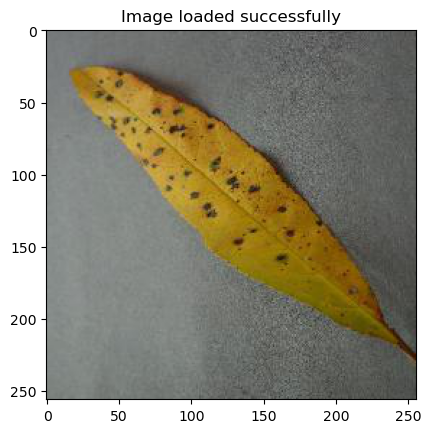

In [328]:
Peach_Bacterial_spot = load_image("Dataset/Plant_Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Peach___Bacterial_spot/0bb77fcc-27ca-474f-beae-6b3519727cf9___Rutg._Bact.S 1901.JPG")
prep_img = normalize(Peach_Bacterial_spot, device)
print("predicted class:", predict(prep_img, best_trained_model))

In [332]:
def normalize_for_layers_view(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ])
    image = preprocess(image).unsqueeze(0).to(device)
    return image
prep_img = normalize_for_layers_view(Peach_Bacterial_spot, device)

In [333]:
def layer_outputs(image, model):

    outputs = []
    names = []
        
    for layer in model.conv_layer:
    
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)  # take the mean
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize=(30, 50))

    for i in range(len(output_im)):
        a = fig.add_subplot(8, 4, i+1)
        imgplot = plt.imshow(output_im[i])
        a.set_axis_off()
        a.set_title(names[i].partition('(')[0], fontsize=30)
    plt.tight_layout()

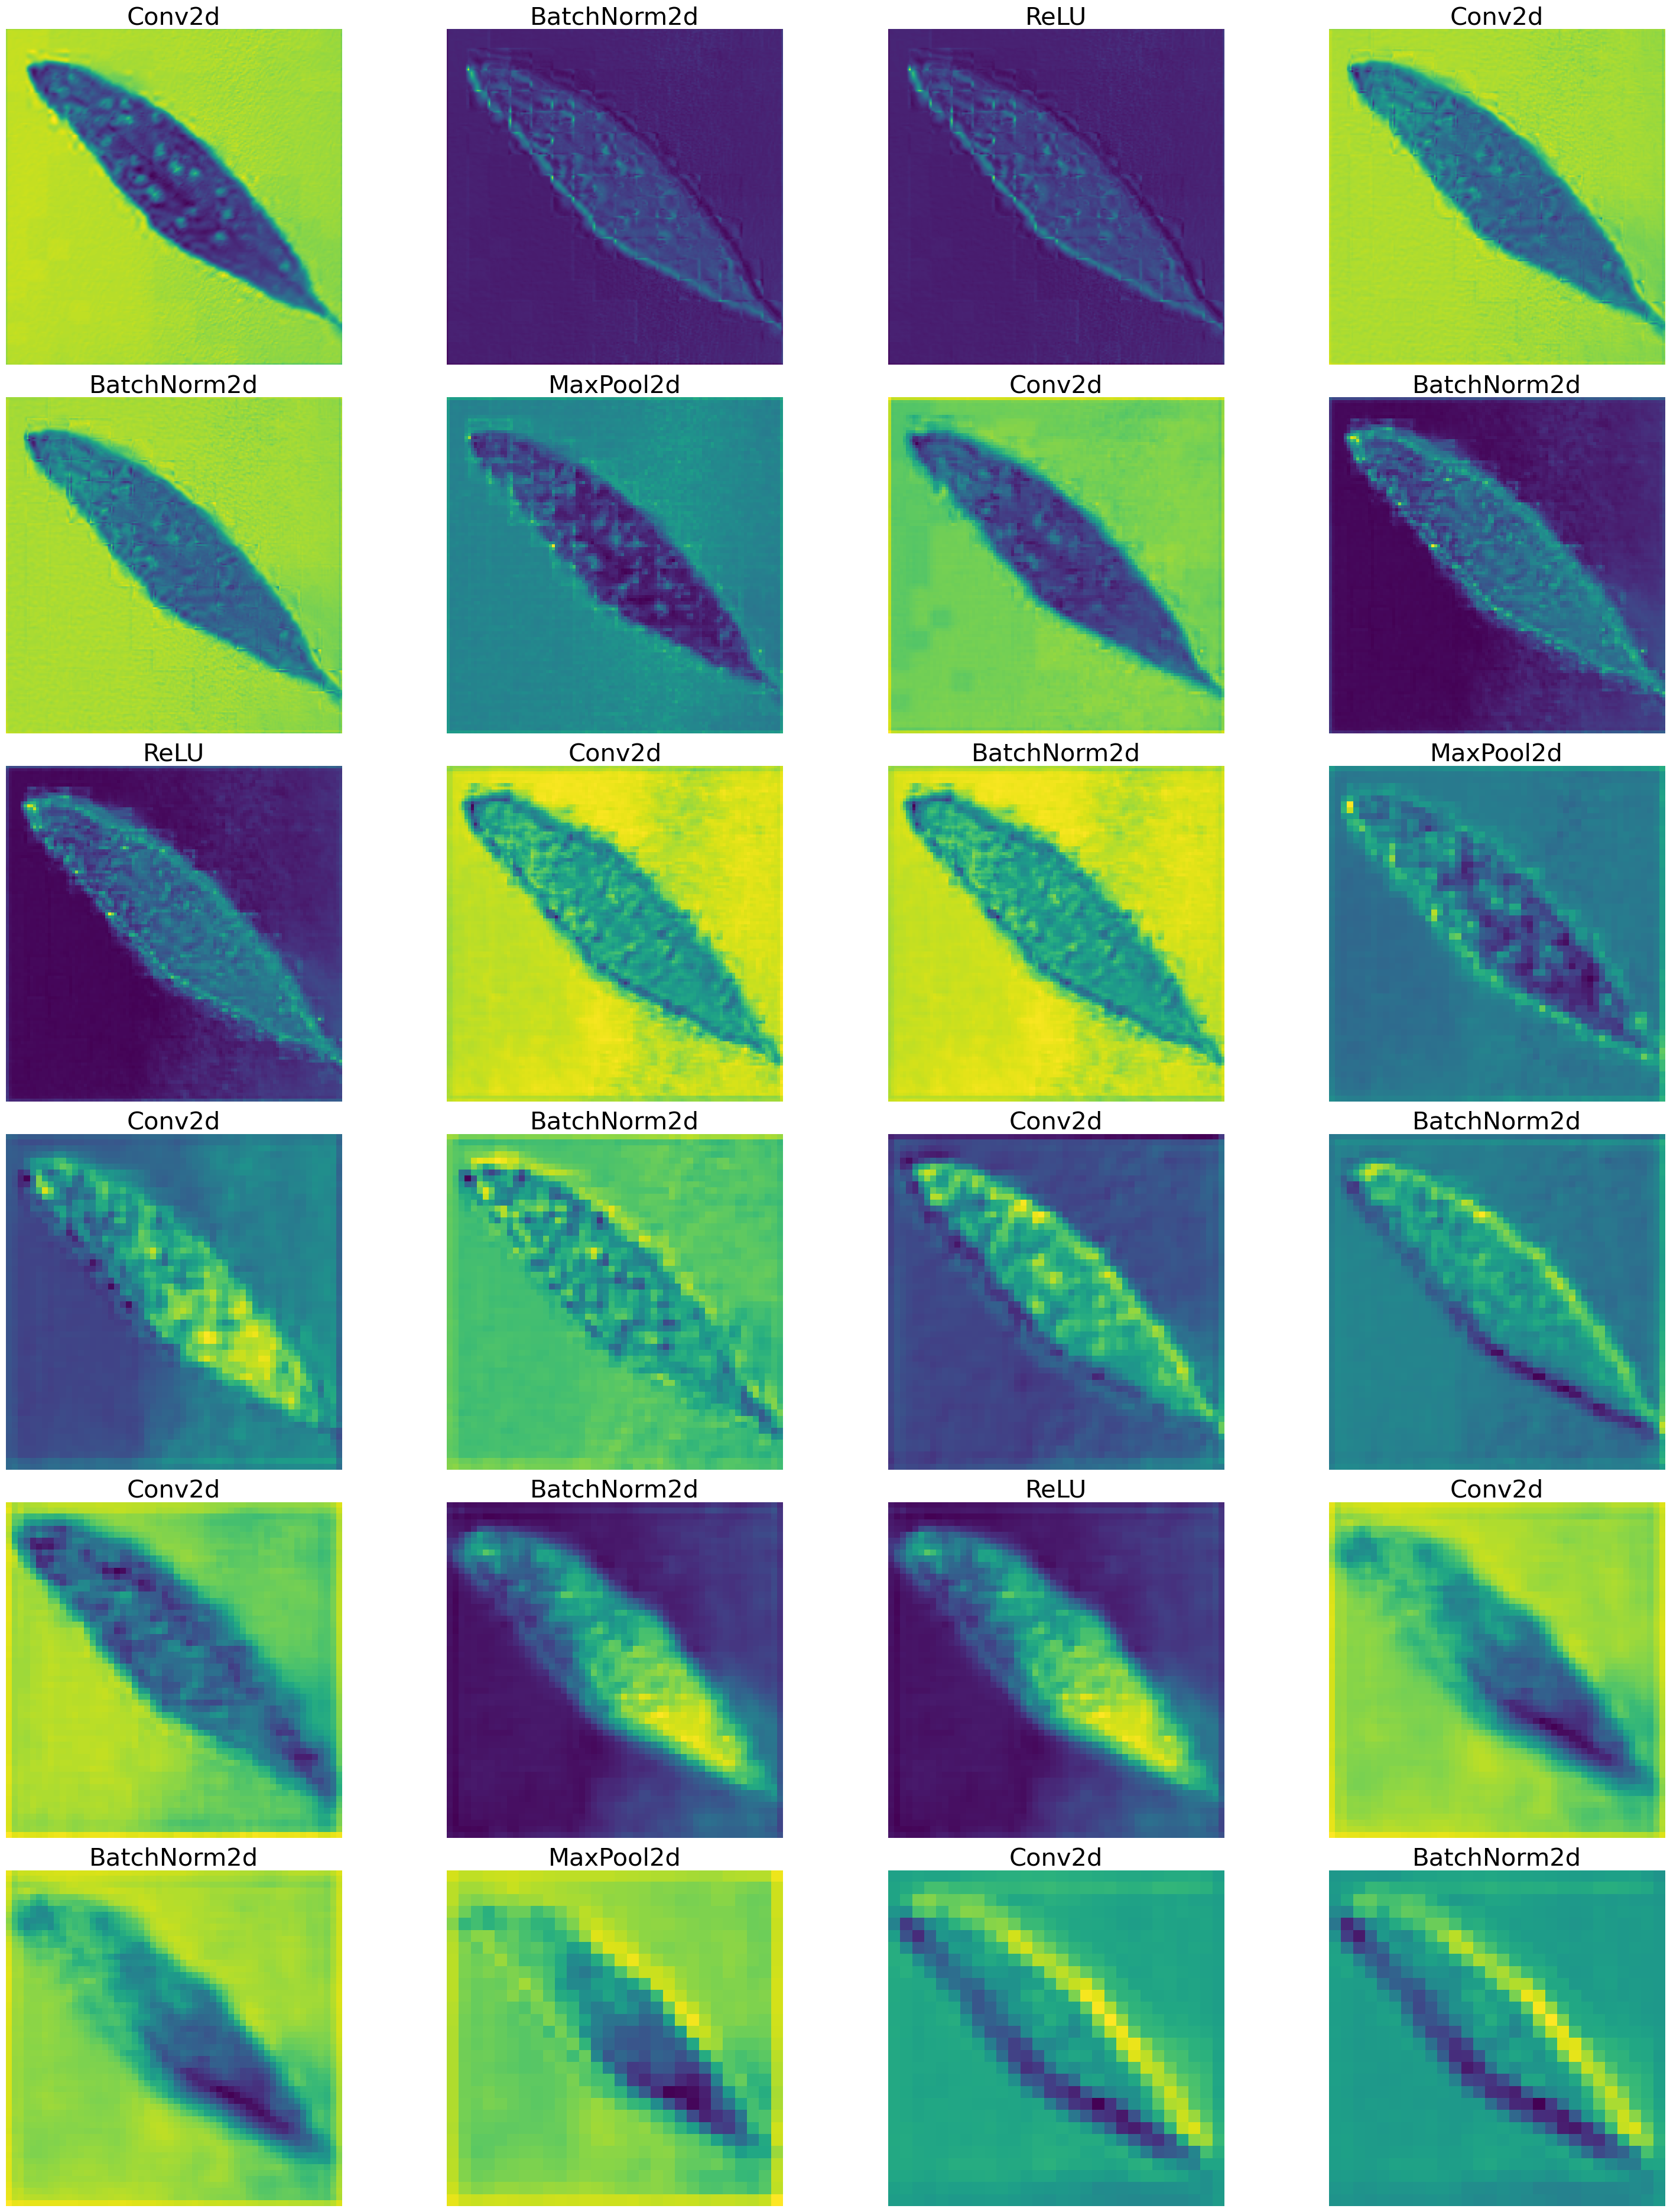

In [334]:
layer_outputs(prep_img, best_trained_model)

In [47]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params["batch size"], shuffle=False)
test_accuracy, _ = calculate_accuracy(best_trained_model, test_loader, device)
print(f"test accuracy:{test_accuracy}")

test accuracy:93.93939393939394
